# German Traffic Sign Classifier using a LeNet based Convolutional Network

## Pipeline Approach

In this project, I'm building pipelines to classify the traffic signs from the [German Traffic Sign Benchmarks](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

I'm using the scikit-learn's pipeline framework in order to train the model with various combinations of transformations and estimators.

The starting model is a convolutional network based on the [LeNet](http://yann.lecun.com/exdb/lenet/) architecture by Yann LeCun.  LeNet was originally designed for handwritten and machine-printed character recognition. 

The project is explained in the following sections.

- Data Exploratory Analysis
- Model Implementation
- Pipeline Implementation
- Preprocessing
- Model Improvement
- Testing and Results

# Data Exploratory Analysis

The traffic sign images were taken from the [German Traffic Sign Benchmarks](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).  

- http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Training_Images.zip
- http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Test_Images.zip
- http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Test_GT.zip

```
> mkdir data

> # use wget or curl 
> wget http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Training_Images.zip
> unzip GTSRB_Final_Training_Images.zip
> mv GTSRB/Final_Training data/

> wget http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Test_Images.zip
> unzip GTSRB_Final_Test_Images.zip
> mv GTSRB/Final_Test/ data/

> wget http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Test_GT.zip
> unzip GTSRB_Final_Test_GT.zip
> mv GT-final_test.csv data/Final_Test/Images/
```

## Training Data Folder Structure

The training images are organized in folders by category.  Each folder is meant for one category (i.e. stop sign) and has a label file (.csv) which is actually semi-colon delimited (not comma delimited).

```
data
 + Final_Training
    + Images
        + 00000
            + 00000_00000.ppm
            + 00000_00001.ppm
            ...    
            + GT-00000.csv
        + 00001
            + 00000_00000.ppm
            + 00000_00001.ppm
            ...    
            + GT-00001.csv
        ...
```

All images are stored in the PPM format ([Portable Pixmap, P6](http://en.wikipedia.org/wiki/Netpbm_format)).  You'll need to install both `matplotlib` and `pillow` to handle such image format.  If you use one of the evironments yml files in this repository, this will be taken care of.

## Import Required Libraries

In [1]:
import glob
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
from tensorflow.compat.v1.layers import flatten
from pipeline import NeuralNetwork, make_adam, Session, build_pipeline

matplotlib.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

ModuleNotFoundError: No module named 'pandas'

## Loading Training Data

All train image paths are combined into one dataframe for convenience.

In [19]:
TRAIN_IMAGE_DIR = 'data\\Final_Training\\Images'

dfs = []
for train_file in glob.glob(os.path.join(TRAIN_IMAGE_DIR, '*/GT-*.csv')):
    folder = train_file.split('\\')[3]
    df = pd.read_csv(train_file, sep=';')
    df['Filename'] = df['Filename'].apply(lambda x: os.path.join(TRAIN_IMAGE_DIR, folder, x))
    dfs.append(df)

In [20]:
train_df = pd.concat(dfs, ignore_index=True)
train_df.head()

Filename  Width  Height  Roi.X1  \
0  data\Final_Training\Images\00000\00000_00000.ppm     29      30       5   
1  data\Final_Training\Images\00000\00000_00001.ppm     30      30       5   
2  data\Final_Training\Images\00000\00000_00002.ppm     30      30       5   
3  data\Final_Training\Images\00000\00000_00003.ppm     31      31       5   
4  data\Final_Training\Images\00000\00000_00004.ppm     30      32       5   

   Roi.Y1  Roi.X2  Roi.Y2  ClassId  
0       6      24      25        0  
1       5      25      25        0  
2       5      25      25        0  
3       5      26      26        0  
4       6      25      26        0

**Annotation format**
- Filename: Filename of corresponding image
- Width: Width of the image
- Height: Height of the image
- ROI.x1: X-coordinate of top-left corner of traffic sign bounding box
- ROI.y1: Y-coordinate of top-left corner of traffic sign bounding box
- ROI.x2: X-coordinate of bottom-right corner of traffic sign bounding box
- ROI.y2: Y-coordinate of bottom-right corner of traffic sign bounding box
- ClassId: Assigned class label

The following points are worth mentioning:
- Image sizes are not fixed
- Sign sizes are not fixed
- Sign's center location is not fixed

Later on, I'll examine sample images to further clarify those points.

## Class Distribution

There are 43 traffic sign classes in 39,209 training images.

In [21]:
N_CLASSES = np.unique(train_df['ClassId']).size  # keep this for later

print("Number of training images : {:>5}".format(train_df.shape[0]))
print("Number of classes         : {:>5}".format(N_CLASSES))

Number of training images : 39209
Number of classes         :    43


The distribution of classes are very skewed.

In [22]:
def show_class_distribution(classIDs, title):
    """
    Plot the traffic sign class distribution
    """
    plt.figure(figsize=(15, 5))
    plt.title('Class ID distribution for {}'.format(title))
    plt.hist(classIDs, bins=N_CLASSES)
    plt.show()

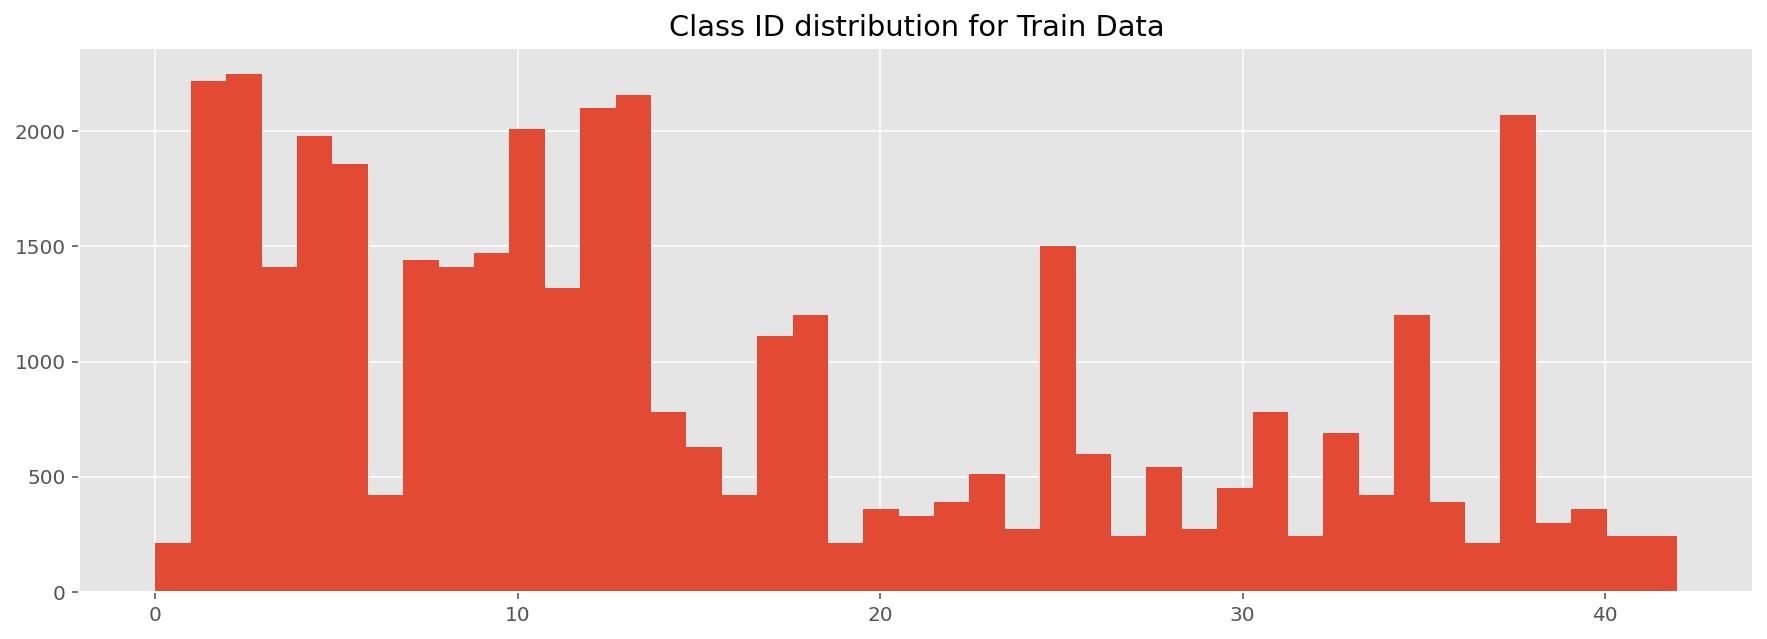

In [23]:
show_class_distribution(train_df['ClassId'], 'Train Data')

The name of each sign are stored in sign_names.csv file.  We can use it see the distribution per sign names.

In [24]:
sign_name_df = pd.read_csv('sign_names.csv', index_col='ClassId')
sign_name_df.head()

SignName
ClassId                      
0        Speed limit (20km/h)
1        Speed limit (30km/h)
2        Speed limit (50km/h)
3        Speed limit (60km/h)
4        Speed limit (70km/h)

In [25]:
sign_name_df['Occurence'] = [sum(train_df['ClassId']==c) for c in range(N_CLASSES)]
sign_name_df.sort_values('Occurence', ascending=False)

SignName  Occurence
ClassId                                                              
2                                     Speed limit (50km/h)       2250
1                                     Speed limit (30km/h)       2220
13                                                   Yield       2160
12                                           Priority road       2100
38                                              Keep right       2070
10            No passing for vehicles over 3.5 metric tons       2010
4                                     Speed limit (70km/h)       1980
5                                     Speed limit (80km/h)       1860
25                                               Road work       1500
9                                               No passing       1470
7                                    Speed limit (100km/h)       1440
3                                     Speed limit (60km/h)       1410
8                                    Speed limit (120km/h)       1410
11                   Right-of-way at the next intersection       1320
35                                              Ahead only       1200
18                                         General caution       1200
17                                                No entry       1110
31                                   Wild animals crossing        780
14                                                    Stop        780
33                                        Turn right ahead        689
15                                             No vehicles        630
26                                         Traffic signals        600
28                                       Children crossing        540
23                                           Slippery road        510
30                                      Beware of ice/snow        450
16                Vehicles over 3.5 metric tons prohibited        420
34                                         Turn left ahead        420
6                              End of speed limit (80km/h)        420
36                                    Go straight or right        390
22                                              Bumpy road        390
40                                    Roundabout mandatory        360
20                            Dangerous curve to the right        360
21                                            Double curve        330
39                                               Keep left        300
29                                       Bicycles crossing        270
24                               Road narrows on the right        270
41                                       End of no passing        240
42       End of no passing by vehicles over 3.5 metric ...        240
32                     End of all speed and passing limits        240
27                                             Pedestrians        240
37                                     Go straight or left        210
19                             Dangerous curve to the left        210
0                                     Speed limit (20km/h)        210

The following constant is defined for later use.

In [26]:
SIGN_NAMES = sign_name_df.SignName.values
SIGN_NAMES[2]

'Speed limit (50km/h)'

## Sample Images

Let's examine some random images:

In [27]:
def load_image(image_file):
    """
    Read image file into numpy array (RGB)
    """
    return plt.imread(image_file)

In [28]:
def get_samples(image_data, num_samples, class_id=None):
    """
    Randomly select image filenames and their class IDs
    """
    if class_id is not None:
        image_data = image_data[image_data['ClassId']==class_id]
    indices = np.random.choice(image_data.shape[0], size=num_samples, replace=False)
    return image_data.iloc[indices][['Filename', 'ClassId']].values

In [29]:
def show_images(image_data, cols=5, sign_names=None, show_shape=False, func=None):
    """
    Given a list of image file paths, load images and show them.
    """
    num_images = len(image_data)
    rows = num_images//cols
    plt.figure(figsize=(cols*3,rows*2.5))
    for i, (image_file, label) in enumerate(image_data):
        image = load_image(image_file)
        if func is not None:
            image = func(image)
        plt.subplot(rows, cols, i+1)
        plt.imshow(image)
        if sign_names is not None:
            plt.text(0, 0, '{}: {}'.format(label, sign_names[label]), color='k',backgroundcolor='c', fontsize=8)        
        if show_shape:
            plt.text(0, image.shape[0], '{}'.format(image.shape), color='k',backgroundcolor='y', fontsize=8)        
        plt.xticks([])
        plt.yticks([])
    plt.show()

The below are 20 random sample images from the train set.

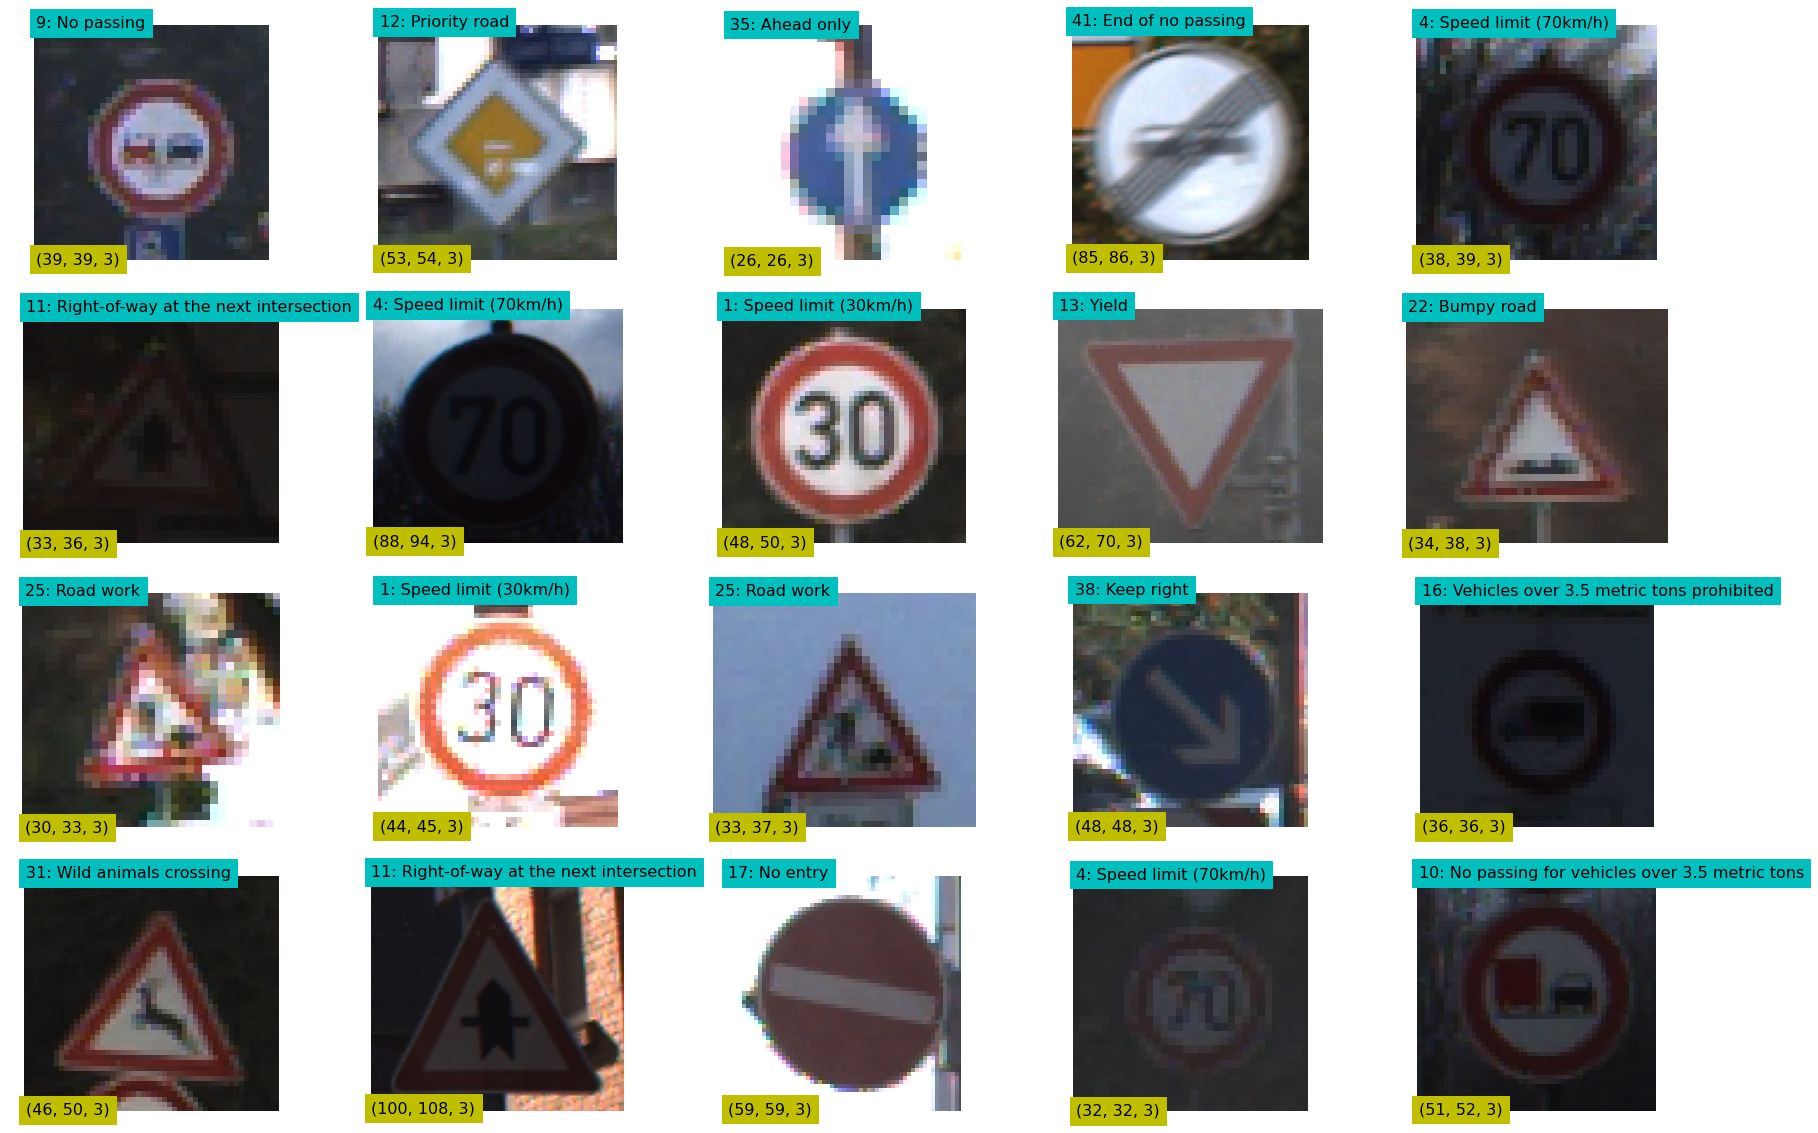

In [30]:
sample_data = get_samples(train_df, 20)
show_images(sample_data, sign_names=SIGN_NAMES, show_shape=True)

Speed limit (50km/h)


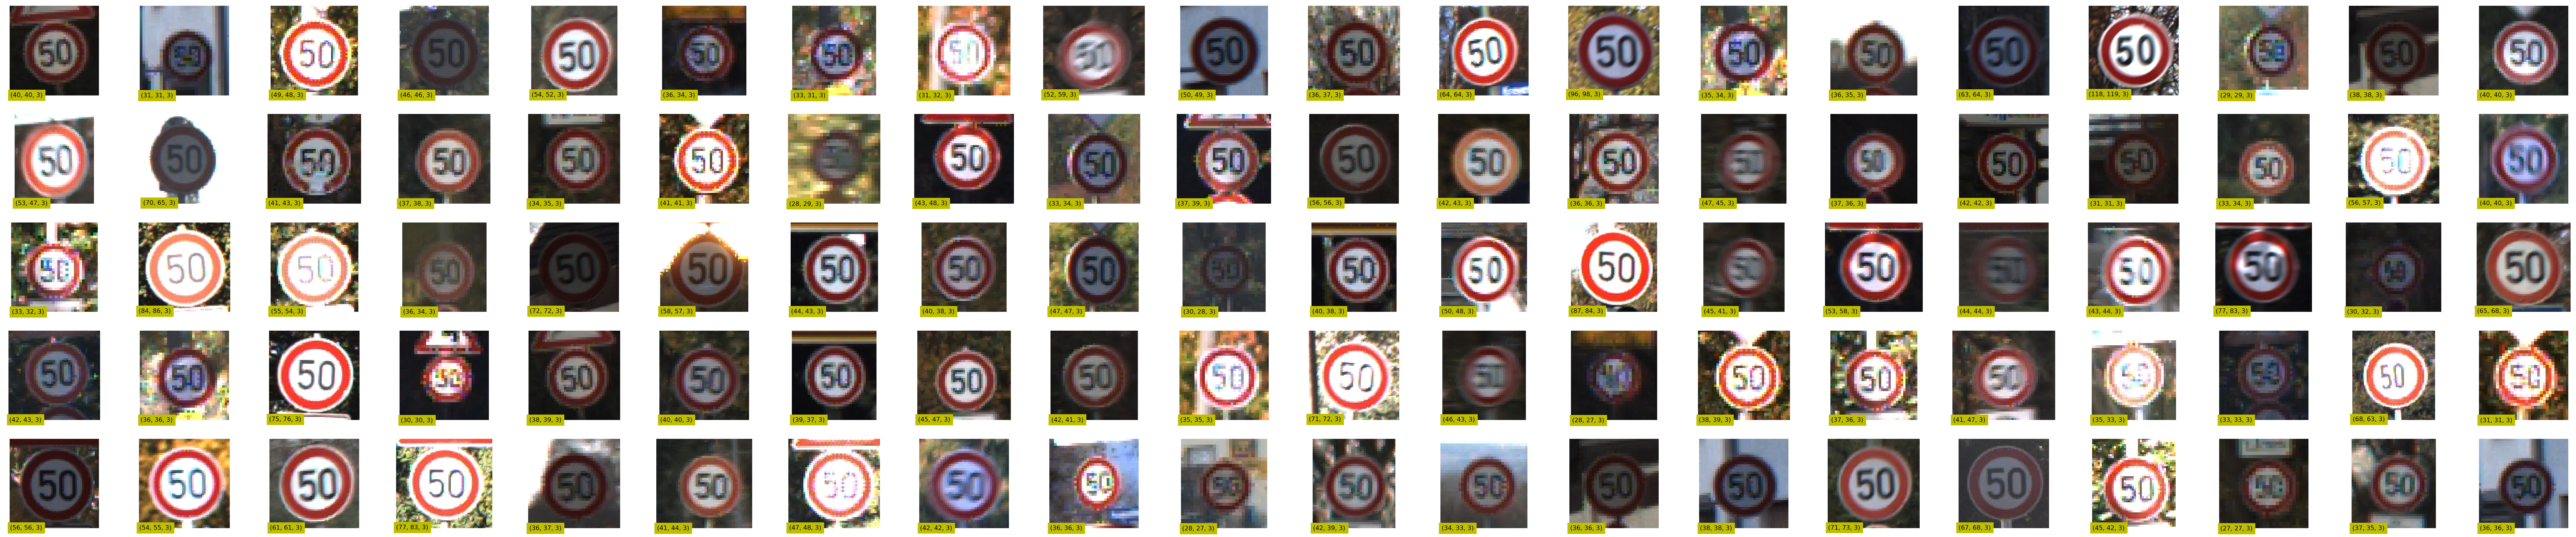

In [31]:
print(SIGN_NAMES[2])
show_images(get_samples(train_df, 100, class_id=2), cols=20, show_shape=True)

Looking at the sample images, the following image characteristics are confirmed:

- The images comes in different sizes  
- The darkness / brightness of those images are fairly random
- The images may be slightly rotated
- The images may not be facing straight
- The images may not be exactly centered
  
The first point will be handled in the image pre-processing, and the remaining points will be handled in the image augmentation.

## Train and Validation Data set

Train and validation data set are created from the training data.

In [32]:
X = train_df['Filename'].values
y = train_df['ClassId'].values

print('X data', len(X))

X data 39209


In [33]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, test_size=8000, random_state=0)

print('X_train:', len(X_train))
print('X_valid:', len(X_valid))

X_train: 31209
X_valid: 8000


#  Model Implementation

## Model Architecture

The model is based on [LeNet](http://yann.lecun.com/exdb/lenet/) by Yann LeCun.  It is a convolutional neural network designed to recognize visual patterns directly from pixel images with minimal preprocessing.  It can handle hand-written characters very well. 

![LeNet](images/lenet.png)

Source: http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf

- The inputs are 32x32 (Black-White 1 channel) images
- LeNet uses 2x2 sub-sampling (valid padding, max pooling) in convolutional layers (no dropout)
- LeNet uses a sigmoid squashing function - a scaled hyperbolic tangent: $Atanh(Sa)$ where A=1.7159 and S=2/3
- LeNet has one 7x12 bitmap for each class, which is a label.  There are 10 classes (the digits '0' - '9')
- 7x12 = 84 which is why the output is 84
- The output is compared with all the labels (bitmaps) to calculate the error
- The class with the smallest error is an estimated digit value

Our model is adapted from the LeNet as follows.  

- The inputs are 32x32 (RGB - 3 channels) images
- The activation function is ReLU except for the output layer which uses Softmax
- The output has 43 classes

|Layer                       | Shape    |
|----------------------------|:--------:|
|Input                       | 32x32x3  |
|Convolution (valid, 5x5x6)  | 28x28x6  |
|Max Pooling (valid, 2x2)    | 14x14x6  |
|Activation  (ReLU)          | 14x14x6  |
|Convolution (valid, 5x5x16) | 10x10x16 |
|Max Pooling (valid, 2x2)    | 5x5x16   |
|Activation  (ReLU)          | 5x5x16   |
|Flatten                     | 400      |
|Dense                       | 120      |
|Activation  (ReLU)          | 120      |
|Dense                       | 43       |
|Activation  (Softmax)       | 43       |

## Model Implementation

The NeuralNetwork class is defined to provide common operations in neural network using Tensorflow.  See the network.py for details.

The first network (based on LeNet) is defined as follows:

In [34]:
INPUT_SHAPE = (32, 32, 3)

def make_network1(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
            .input(input_shape)
            .conv([5, 5, 6])
            .max_pool()
            .relu()
            .conv([5, 5, 16])
            .max_pool()
            .relu()
            .flatten()
            .dense(120)
            .relu()
            .dense(N_CLASSES))

## Pipeline Implementation

We are using the scikit-learn's pipeline framework to handle various pipeline scenarios.  See pipeline.py for details.

Once made, a pipeline can be trained and evaluated using the function below:

In [35]:
def train_evaluate(pipeline, epochs=5, samples_per_epoch=50000, train=(X_train, y_train), test=(X_valid, y_valid)):
    """
    Repeat the training for the epochs and evaluate the performance
    """
    X, y = train
    learning_curve = []
    for i in range(epochs):
        indices = np.random.choice(len(X), size=samples_per_epoch)
        pipeline.fit(X[indices], y[indices])
        scores = [pipeline.score(*train), pipeline.score(*test)]
        learning_curve.append([i, *scores])
        print("Epoch: {:>3} Train Score: {:.3f} Evaluation Score: {:.3f}".format(i, *scores))
    return np.array(learning_curve).T # (epochs, train scores, eval scores)

### The First Performance

Let's train a network using the first network.  This performance is our initial benchmark.

In [38]:
def resize_image(image, shape=INPUT_SHAPE[:2]):
    return cv2.resize(image, shape)

loader = lambda image_file: resize_image(load_image(image_file))

In [71]:
with Session() as session:
    functions = [loader]
    pipeline = build_pipeline(functions, session, make_network1(), make_adam(1.0e-3))
    train_evaluate(pipeline)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use keras.layers.Flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Epoch:   0 Train Score: 0.879 Evaluation Score: 0.860
Epoch:   1 Train Score: 0.943 Evaluation Score: 0.917
Epoch:   2 Train Score: 0.958 Evaluation Score: 0.930
Epoch:   3 Train Score: 0.964 Evaluation Score: 0.937
Epoch:   4 Train Score: 0.956 Evaluation Score: 0.929


**Observation**:

This proves the network is working properly.  The performance is pretty good for the barebone network.

I can see a bit of overfitting.  This is likely because the network is exposed to the same images over and over since I'm using 5 epochs (50K samples per epoch).  At this moment, it is good to see the network is able to overfit and not showing high biases.  The network can handle these images and able to learn from the data.

# Preprocessing

## Image Augmentation

As the training set has very skewed distribution, if I simply increases the epochs or samples per epoch, the network will overfit to the training set.  Hence, we should generate more training data using image augmentation.

In [41]:
def random_brightness(image, ratio):
    """
    Randomly adjust brightness of the image.
    """
    # HSV (Hue, Saturation, Value) is also called HSB ('B' for Brightness).
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    brightness = np.float64(hsv[:, :, 2])
    brightness = brightness * (1.0 + np.random.uniform(-ratio, ratio))
    brightness[brightness>255] = 255
    brightness[brightness<0] = 0
    hsv[:, :, 2] = brightness
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)


def random_rotation(image, angle):
    """
    Randomly rotate the image
    """
    if angle == 0:
        return image
    angle = np.random.uniform(-angle, angle)
    rows, cols = image.shape[:2]
    size = cols, rows
    center = cols/2, rows/2
    scale = 1.0
    rotation = cv2.getRotationMatrix2D(center, angle, scale)
    return cv2.warpAffine(image, rotation, size)


def random_translation(image, translation):
    """
    Randomly move the image
    """
    if translation == 0:
        return 0
    rows, cols = image.shape[:2]
    size = cols, rows
    x = np.random.uniform(-translation, translation)
    y = np.random.uniform(-translation, translation)
    trans = np.float32([[1,0,x],[0,1,y]])
    return cv2.warpAffine(image, trans, size)


def random_shear(image, shear):
    """
    Randomly distort the image
    """
    if shear == 0:
        return image
    rows, cols = image.shape[:2]
    size = cols, rows
    left, right, top, bottom = shear, cols - shear, shear, rows - shear
    dx = np.random.uniform(-shear, shear)
    dy = np.random.uniform(-shear, shear)
    p1 = np.float32([[left   , top],[right   , top   ],[left, bottom]])
    p2 = np.float32([[left+dx, top],[right+dx, top+dy],[left, bottom+dy]])
    move = cv2.getAffineTransform(p1,p2)
    return cv2.warpAffine(image, move, size)
    
    
def augment_image(image, brightness, angle, translation, shear):
    image = random_brightness(image, brightness)
    image = random_rotation(image, angle)
    image = random_translation(image, translation)
    image = random_shear(image, shear)
    return image

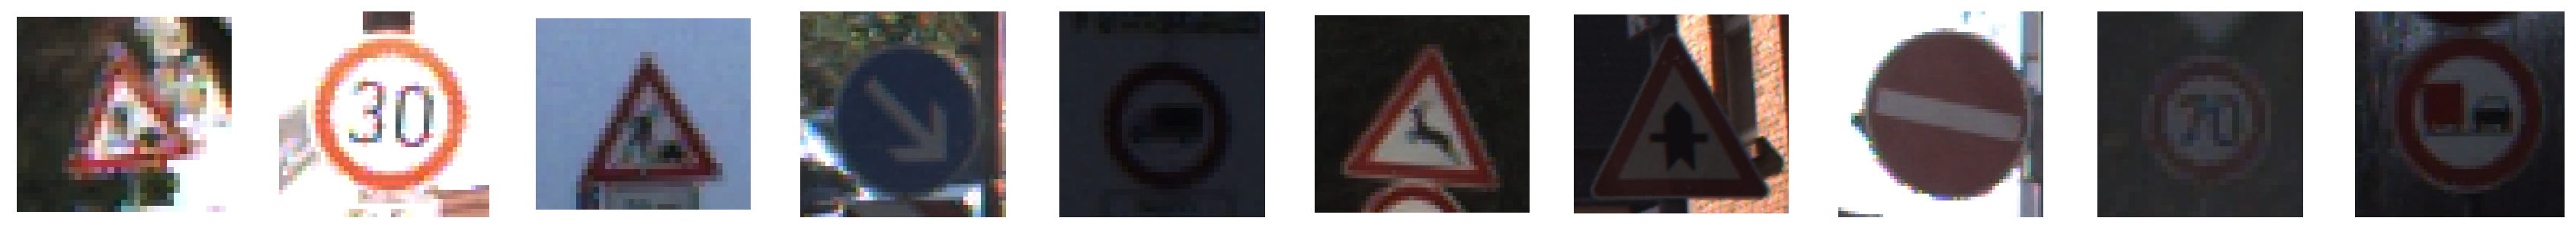

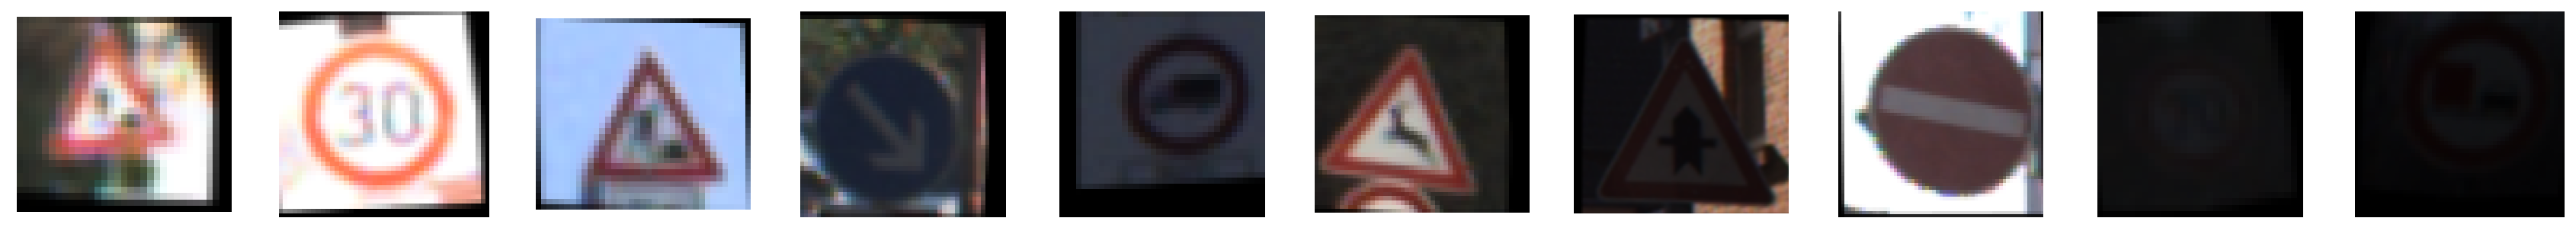

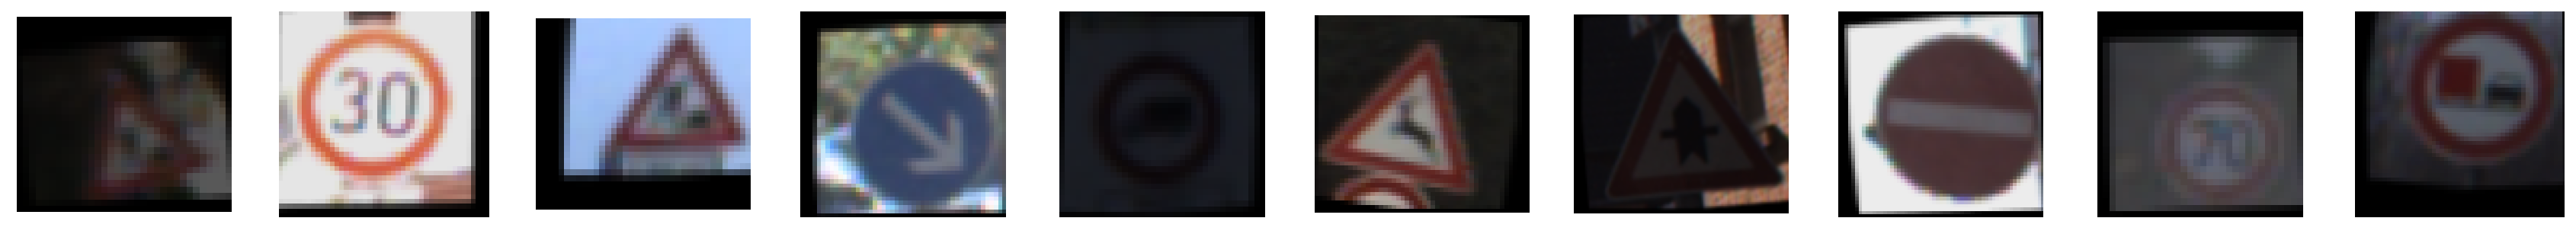

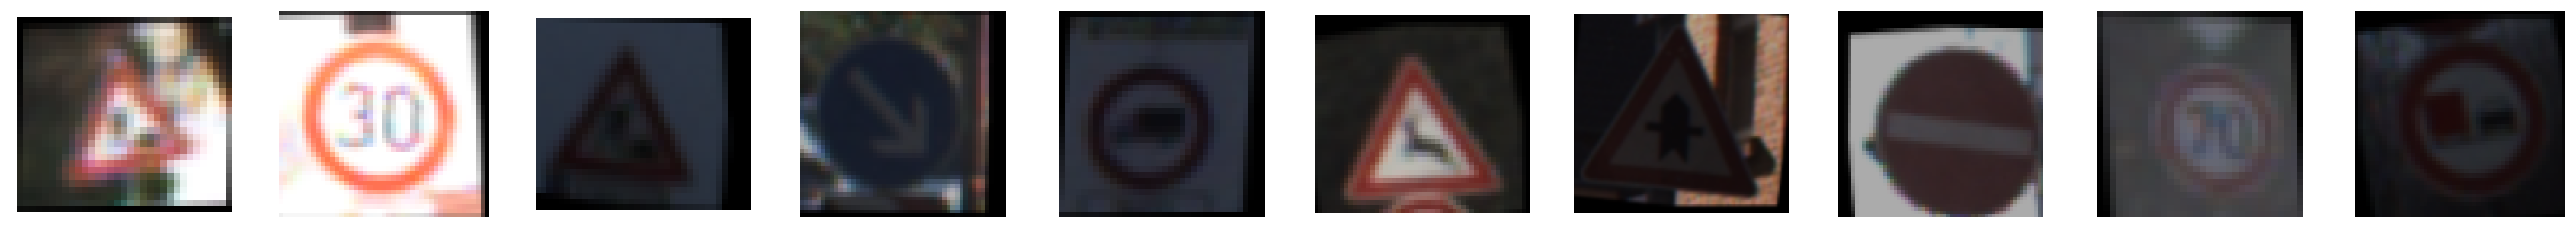

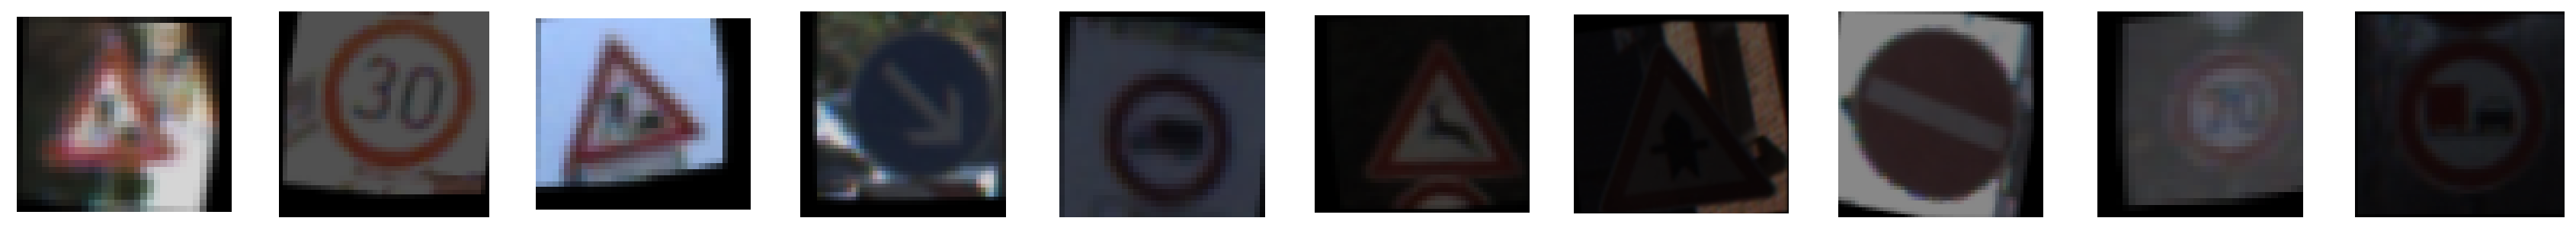

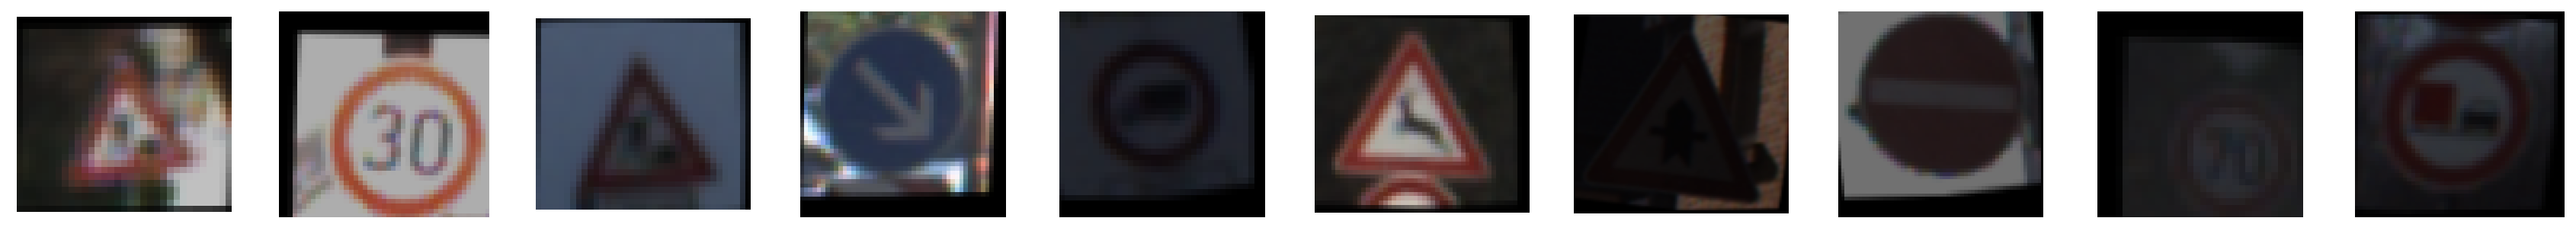

In [42]:
augmenter = lambda x: augment_image(x, brightness=0.7, angle=10, translation=5, shear=2)

show_images(sample_data[10:], cols=10) # original
for _ in range(5):
    show_images(sample_data[10:], cols=10, func=augmenter)

In [77]:
with Session() as session:
    functions = [loader, augmenter]
    pipeline = build_pipeline(functions, session, make_network1(), make_adam(1.0e-3))
    train_evaluate(pipeline)

Epoch:   0 Train Score: 0.189 Evaluation Score: 0.188
Epoch:   1 Train Score: 0.413 Evaluation Score: 0.409
Epoch:   2 Train Score: 0.595 Evaluation Score: 0.596
Epoch:   3 Train Score: 0.651 Evaluation Score: 0.656
Epoch:   4 Train Score: 0.719 Evaluation Score: 0.709


**Obervation**:

The hyper-perameters like brightness, rotation, translation, shear parameters are manually tuned by looking at the randomly altered images.  If the alteration is too great, it is not realistic.  The same way that horizontal flip is not included, too big change like rotating 90 degree should not be used.

The performance with the augmentation is much worse than without it.  There are two possible reasons:

1. the network is not robust to these changes (it was memorizing than generalizing)
2. the training requires more epochs (it takes more time to train with larger data)

Let's see how other preprocessing can improve the performance first.  I hope the normalization and other technique will make the learning easier for the network.  Once that's done, I will use much bigger epochs to properly measure the performance.

## Data Normalization

The below will test various normalization technique to see which one has the best performance.

In [78]:
normalizers = [('x - 127.5',              lambda x: x - 127.5), 
               ('x/127.5 - 1.0',          lambda x: x/127.5 - 1.0), 
               ('x/255.0 - 0.5',          lambda x: x/255.0 - 0.5),
               ('x - x.mean()',           lambda x: x - x.mean()),
               ('(x - x.mean())/x.std()', lambda x: (x - x.mean())/x.std())]
                
for name, normalizer in normalizers:
    print('Normalizer: {}'.format(name))
    with Session() as session:
        functions = [loader, augmenter, normalizer]
        pipeline = build_pipeline(functions, session, make_network1(), make_adam(1.0e-3))
        train_evaluate(pipeline)
    print()

Normalizer: x - 127.5
Epoch:   0 Train Score: 0.281 Evaluation Score: 0.282
Epoch:   1 Train Score: 0.452 Evaluation Score: 0.446
Epoch:   2 Train Score: 0.587 Evaluation Score: 0.580
Epoch:   3 Train Score: 0.660 Evaluation Score: 0.656
Epoch:   4 Train Score: 0.668 Evaluation Score: 0.666

Normalizer: x/127.5 - 1.0
Epoch:   0 Train Score: 0.601 Evaluation Score: 0.600
Epoch:   1 Train Score: 0.737 Evaluation Score: 0.729
Epoch:   2 Train Score: 0.774 Evaluation Score: 0.768
Epoch:   3 Train Score: 0.796 Evaluation Score: 0.814
Epoch:   4 Train Score: 0.846 Evaluation Score: 0.836

Normalizer: x/255.0 - 0.5
Epoch:   0 Train Score: 0.560 Evaluation Score: 0.553
Epoch:   1 Train Score: 0.721 Evaluation Score: 0.712
Epoch:   2 Train Score: 0.787 Evaluation Score: 0.783
Epoch:   3 Train Score: 0.811 Evaluation Score: 0.803
Epoch:   4 Train Score: 0.850 Evaluation Score: 0.846

Normalizer: x - x.mean()
Epoch:   0 Train Score: 0.427 Evaluation Score: 0.428
Epoch:   1 Train Score: 0.565 Eval

**Observaton**:

The performance with any of the normalizations is better than without them.  This clearly shows the importance of the normalizations.  In this experiment, the normalization with `(x-x.mean())/x.std()` produced the best performance.  The performance actually varies randomly at every run.  So, it is not easy to say which one is better than what.  In any case, `(x-x.mean())/x.std()` wins by far.

There are more techniques like using an average image of all training data, etc, which I may try later on.  But for now, I will use the best performing normalization for the rest of the experiment.

In [39]:
normalizer = lambda x: (x - x.mean())/x.std()

## Color Space

Now, we'll try difference color space to see if there is any performance gain.

Note: Gray scale has only one channel so it needs to be handled separately.

**Color Code Reference**:

- http://docs.opencv.org/3.2.0/de/d25/imgproc_color_conversions.html
- https://en.wikipedia.org/wiki/CIE_1931_color_space

In [80]:
# for Gray scale, we need to add the 3rd dimension back (1 channel) as it's expected by the network
converters = [('Gray', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2GRAY)[:, :, np.newaxis]),
              ('HSV', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2HSV)),
              ('HLS', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2HLS)),
              ('Lab', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2Lab)),
              ('Luv', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2Luv)),
              ('XYZ', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2XYZ)),
              ('Yrb', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2YCrCb)),
              ('YUV', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2YUV))]

GRAY_INPUT_SHAPE = (*INPUT_SHAPE[:2], 1)

for name, converter in converters:
    print('Color Space: {}'.format(name))
    with Session() as session:
        functions = [loader, augmenter, converter, normalizer]
        if name == 'Gray':
            network = make_network1(input_shape=GRAY_INPUT_SHAPE) # there is only one channel in gray scale
        else:
            network = make_network1()
        pipeline = build_pipeline(functions, session, network, make_adam(1.0e-3))
        train_evaluate(pipeline)
    print()

Color Space: Gray
Epoch:   0 Train Score: 0.674 Evaluation Score: 0.670
Epoch:   1 Train Score: 0.794 Evaluation Score: 0.794
Epoch:   2 Train Score: 0.836 Evaluation Score: 0.835
Epoch:   3 Train Score: 0.863 Evaluation Score: 0.852
Epoch:   4 Train Score: 0.886 Evaluation Score: 0.879

Color Space: HSV
Epoch:   0 Train Score: 0.541 Evaluation Score: 0.536
Epoch:   1 Train Score: 0.641 Evaluation Score: 0.632
Epoch:   2 Train Score: 0.709 Evaluation Score: 0.707
Epoch:   3 Train Score: 0.742 Evaluation Score: 0.739
Epoch:   4 Train Score: 0.796 Evaluation Score: 0.795

Color Space: HLS
Epoch:   0 Train Score: 0.498 Evaluation Score: 0.495
Epoch:   1 Train Score: 0.631 Evaluation Score: 0.633
Epoch:   2 Train Score: 0.707 Evaluation Score: 0.700
Epoch:   3 Train Score: 0.755 Evaluation Score: 0.745
Epoch:   4 Train Score: 0.798 Evaluation Score: 0.791

Color Space: Lab
Epoch:   0 Train Score: 0.533 Evaluation Score: 0.529
Epoch:   1 Train Score: 0.701 Evaluation Score: 0.698
Epoch:   2

**Observaton**:

RGB (no conversion) is the best which surprised me.  I was expecting the gray scale to be more efficient as the traffic signs are mostly about shapes not colors.  The gray scale would have reduced the dimensionality from 3 color channels to 1, which would make the learning faster/easier.  Apparently, that is not the case.  

Also, I was thinking that the colors in traffic signs are more saturated than that of backgrounds (i.e., trees), and the color space like HSV and HLS might contribute to superior performance.  This was not the case.  Also, now that I saw the result, I realized that I should not assume anything about the background colors.

On a separate note, I noticed that whenever I ran this cell, the result seems slightly different.  For example, gray scale or XYZ sometimes shows better performance than RGB (no conversion).  This could be due to the randomness of image augmentation.  But most of the times, RGB (no conversion) is the best.  If I needed to analyse this further, I'd need to check the histogram of different channels and the performance for each color space.  

But that's the kind of things the network should automatically figure out (i.e., automatic feature engineering).  So, I should not mess with color space at least for now.  It makes the pipeline simpler, too.

I'm done with preprocessing part.

In [43]:
preprocessors = [loader, augmenter, normalizer]

# Model Improvement

I want to try the following to see if I can improve the performance while not causing any overfit.

- more filters in conv layers
- more neurons in dense layers
- more conv layers 
- more dense layers
- different activation like `elu` instead of `relu`
- dropout

The below is to plot the learning curve.

In [53]:
def show_learning_curve(learning_curve):
    epochs, train, valid = learning_curve
    plt.figure(figsize=(10, 10))
    plt.plot(epochs, train, label='train')
    plt.plot(epochs, valid, label='validation')
    plt.title('Learning Curve')
    plt.ylabel('accuracy')
    plt.xlabel('epochs')
    plt.xticks(epochs)
    plt.legend(loc='center right')

These functions are for plotting and printing the confusion matrix.

In [56]:
def plot_confusion_matrix(cm):
    cm = [row/sum(row)   for row in cm]
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm, cmap=plt.cm.Oranges)
    fig.colorbar(cax)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Class IDs')
    plt.ylabel('True Class IDs')
    plt.show()
    

def print_confusion_matrix(cm, sign_names=SIGN_NAMES):
    results = [(i, SIGN_NAMES[i], row[i]/sum(row)*100) for i, row in enumerate(cm)]
    accuracies = []
    for result in sorted(results, key=lambda x: -x[2]):
        print('{:>2} {:<50} {:6.2f}% {:>4}'.format(*result, sum(y_train==result[0])))
        accuracies.append(result[2])
    print('-'*50)
    print('Accuracy: Mean: {:.3f} Std: {:.3f}'.format(np.mean(accuracies), np.std(accuracies)))

## Network 2

Doubling all filters in the convolutional layers and neurons in the dense layers.

Epoch:   0 Train Score: 0.853 Evaluation Score: 0.853
Epoch:   1 Train Score: 0.915 Evaluation Score: 0.914
Epoch:   2 Train Score: 0.940 Evaluation Score: 0.939
Epoch:   3 Train Score: 0.953 Evaluation Score: 0.945
Epoch:   4 Train Score: 0.961 Evaluation Score: 0.961


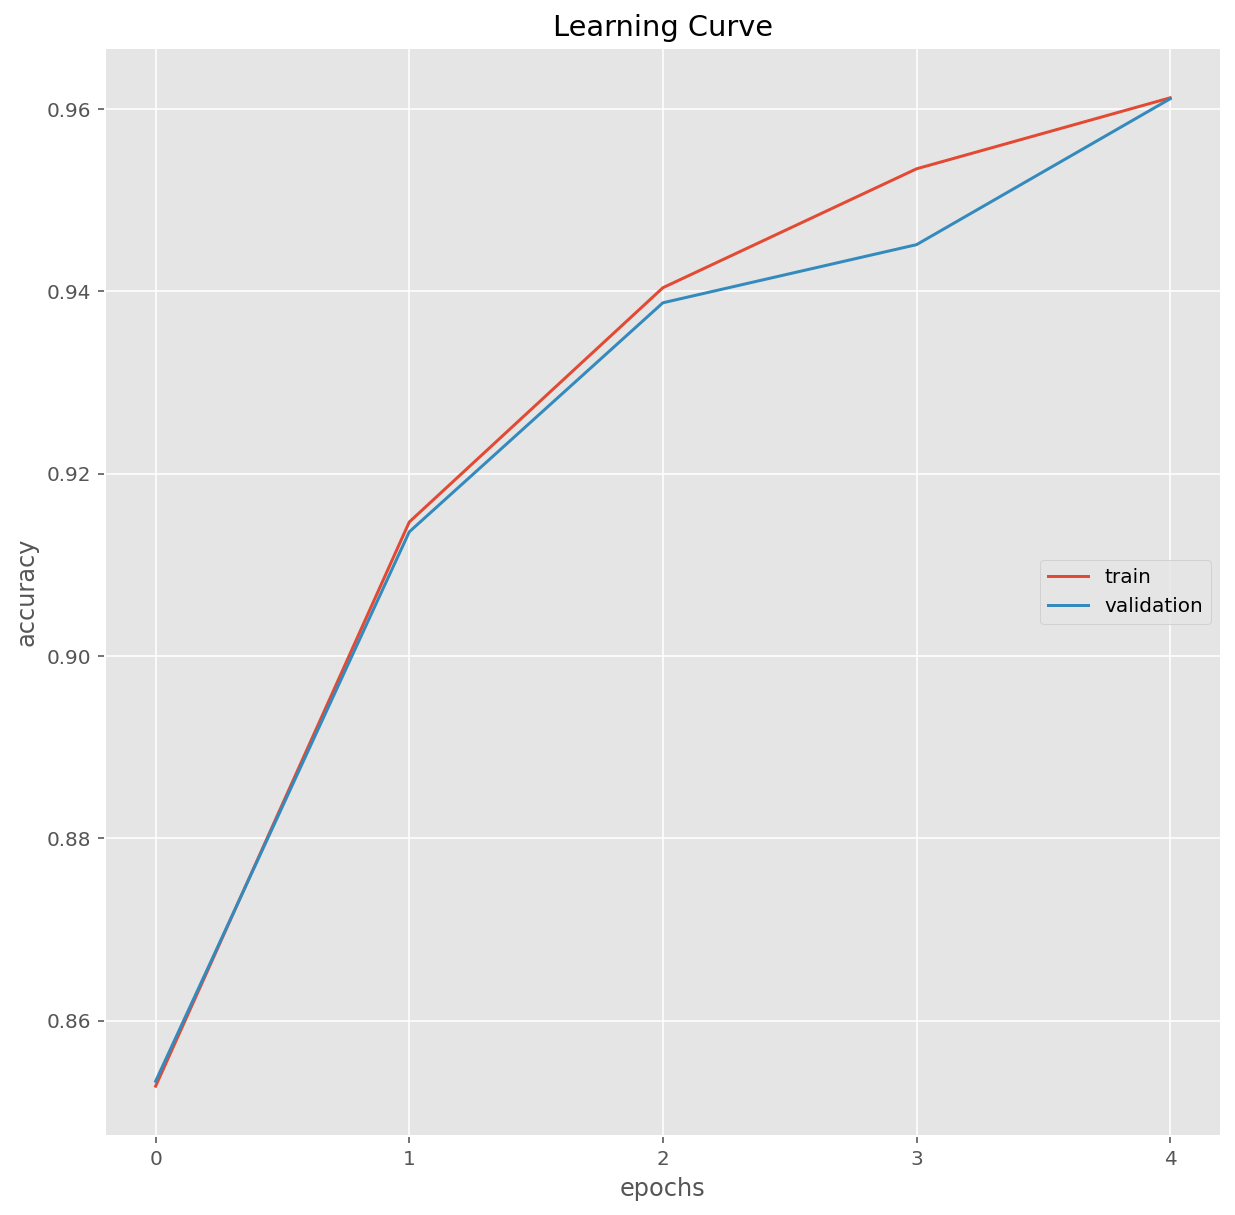

In [84]:
def make_network2(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
            .input(input_shape)
            .conv([5, 5, 12])  # <== doubled
            .max_pool()
            .relu()
            .conv([5, 5, 32])  # <== doubled
            .max_pool()
            .relu()
            .flatten()
            .dense(240) # <== doubled
            .relu()
            .dense(N_CLASSES))

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network2(), make_adam(1.0e-3))
    learning_curve = train_evaluate(pipeline)
    session.save('checkpoint/network2.ckpt')
    
show_learning_curve(learning_curve)

INFO:tensorflow:Restoring parameters from checkpoint/network2.ckpt


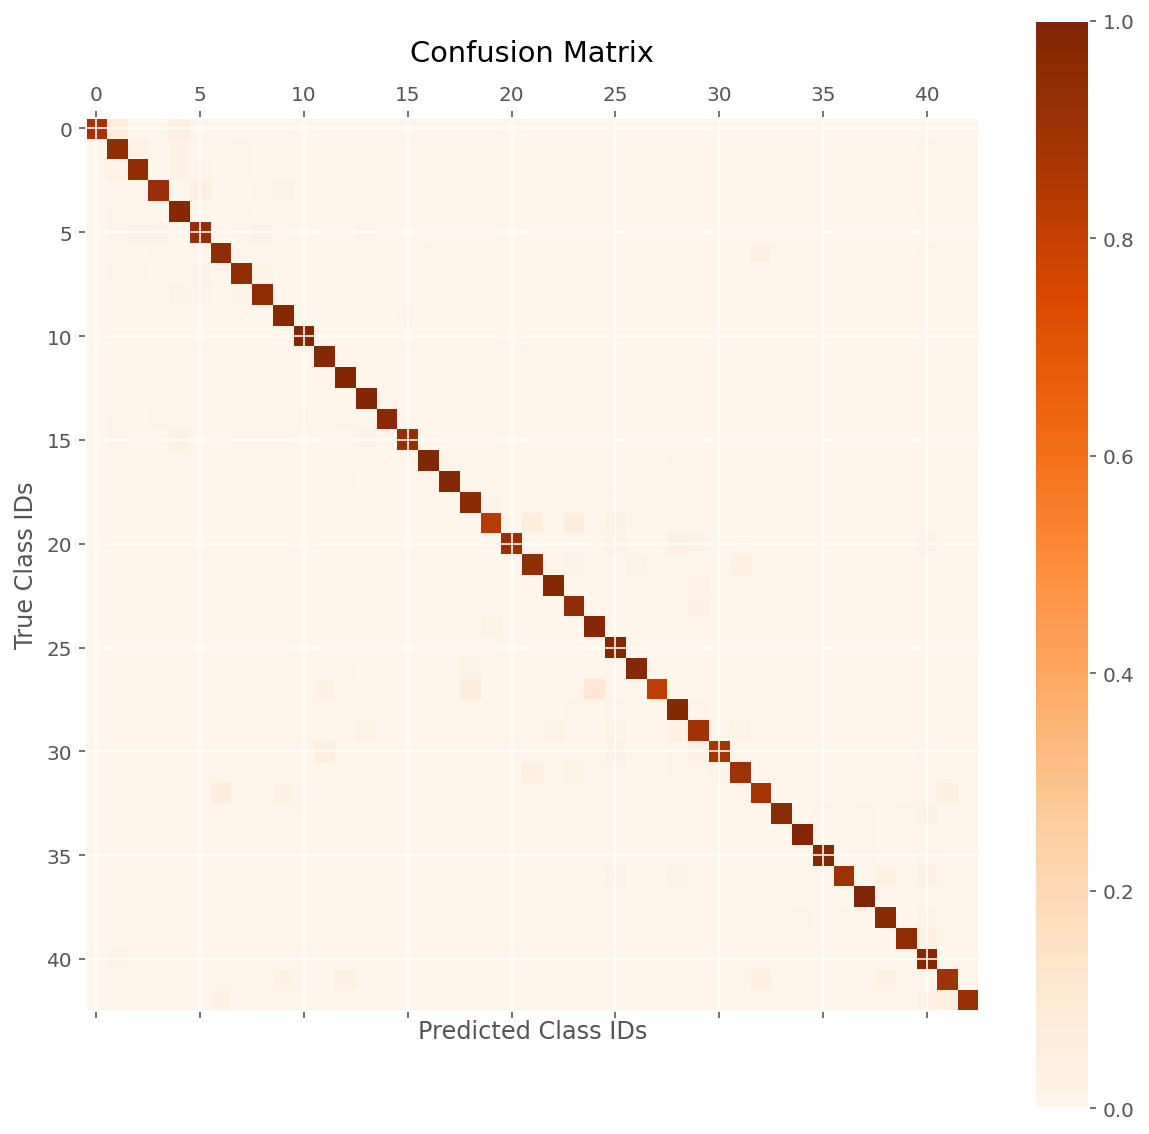

37 Go straight or left                                100.00%  167
12 Priority road                                       99.53% 1672
13 Yield                                               99.32% 1719
16 Vehicles over 3.5 metric tons prohibited            98.84%  334
34 Turn left ahead                                     98.84%  334
35 Ahead only                                          98.78%  955
22 Bumpy road                                          98.75%  310
17 No entry                                            98.67%  884
40 Roundabout mandatory                                98.63%  287
10 No passing for vehicles over 3.5 metric tons        98.54% 1600
25 Road work                                           98.37% 1194
24 Road narrows on the right                           98.18%  215
 9 No passing                                          97.67% 1170
26 Traffic signals                                     97.54%  478
11 Right-of-way at the next intersection               97.40% 

In [85]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network2())
    session.load('checkpoint/network2.ckpt')  
    pred = pipeline.predict(X_valid)
    
# examine confusionconfusion_matrixix
cm = confusion_matrix(y_valid, pred)
plot_confusion_matrix(cm)
print_confusion_matrix(cm)

**Observation**:

The performance improved. The training accuracy is slightly higher than the validation accuracy.  It might be a sign of overfitting but I'll need to see by increasing the complexity of the network.

On a separate note, I could have tried changing layer by layer but changing all three did work so I'm ok with this.

The confusion matrix's mean accuracy is the sum of the mean accuracy for each class divided by the number of class.  It is lower than overall accuracy indicating the larger classes are performing better (or the smaller classes are performing worse).

## Network 3

Futher doubling all filters in the convolutional layers and neurons in the dense layers.

In [67]:
def make_network3(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
            .input(input_shape)
            .conv([5, 5, 24]) # <== doubled
            .max_pool()
            .relu()
            .conv([5, 5, 64]) # <== doubled
            .max_pool()
            .relu()
            .flatten()
            .dense(480)  # <== doubled
            .relu()
            .dense(N_CLASSES))

Epoch:   0 Train Score: 0.915 Evaluation Score: 0.912
Epoch:   1 Train Score: 0.941 Evaluation Score: 0.943
Epoch:   2 Train Score: 0.961 Evaluation Score: 0.959
Epoch:   3 Train Score: 0.962 Evaluation Score: 0.963
Epoch:   4 Train Score: 0.969 Evaluation Score: 0.968


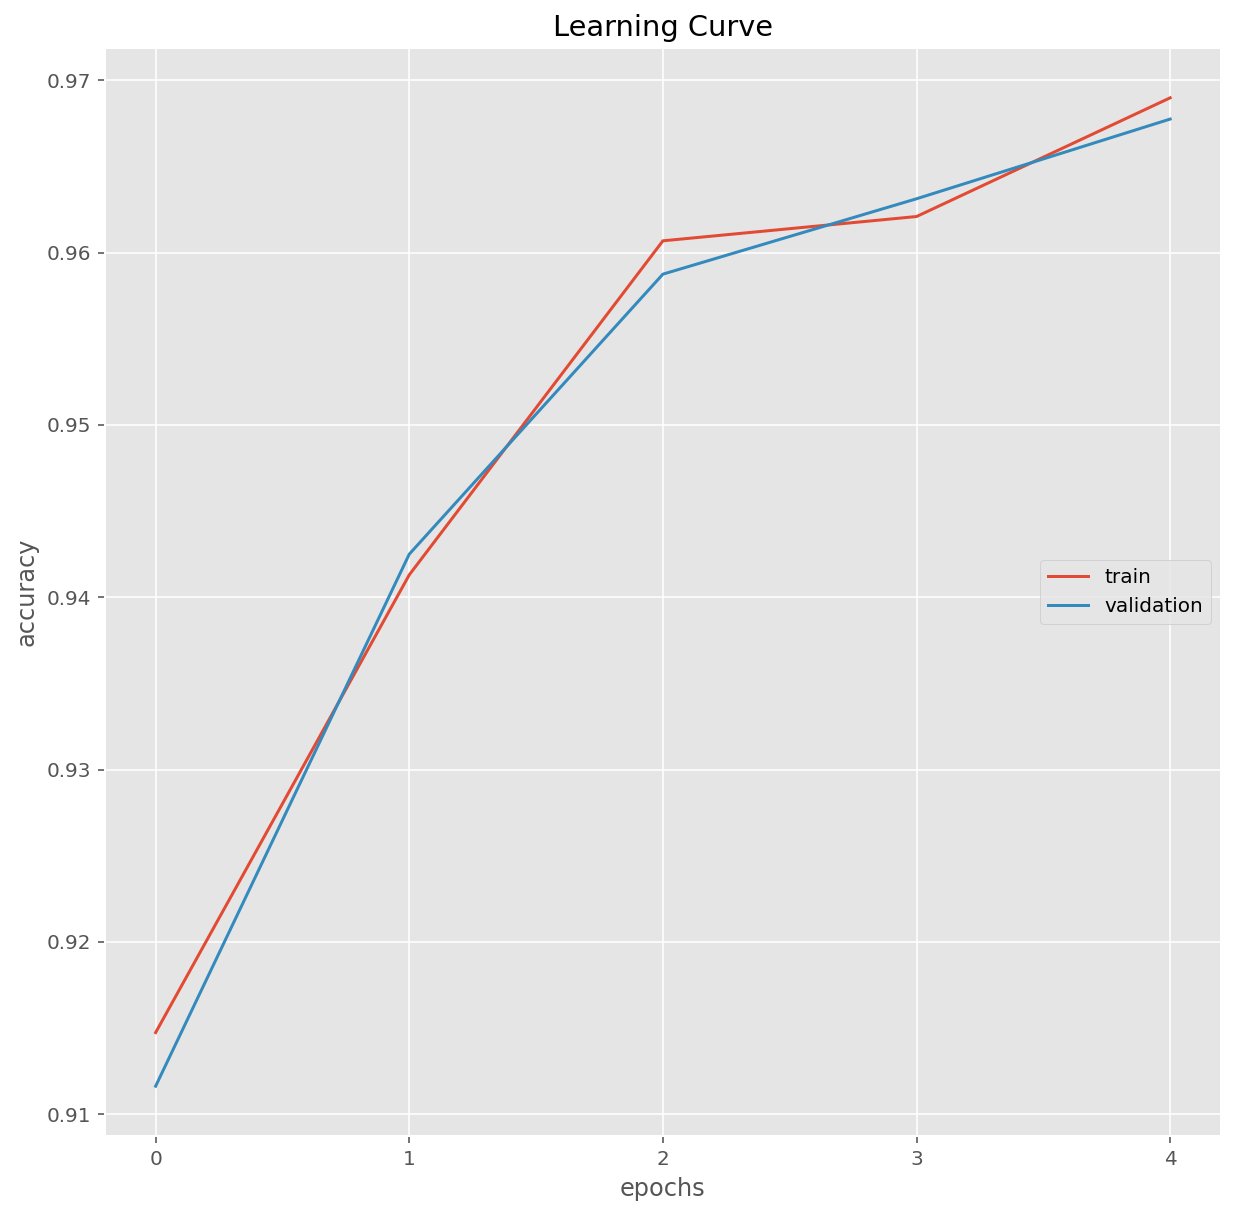

In [86]:


with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network3(), make_adam(1.0e-3))
    learning_curve = train_evaluate(pipeline)
    session.save('checkpoint/network3.ckpt')
    
show_learning_curve(learning_curve)

INFO:tensorflow:Restoring parameters from checkpoint/network3.ckpt


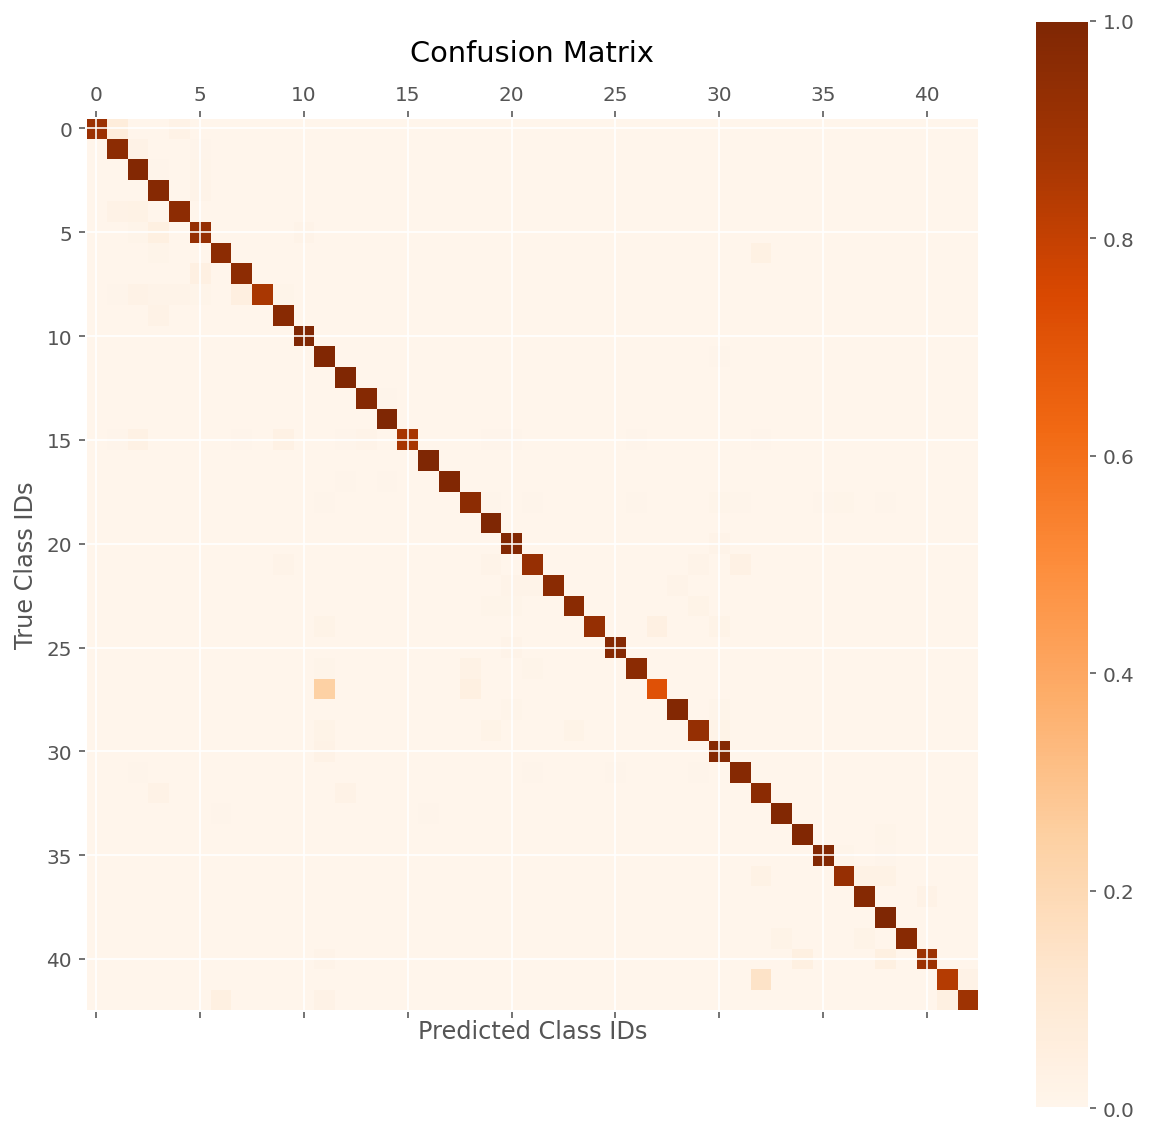

14 Stop                                               100.00%  621
16 Vehicles over 3.5 metric tons prohibited           100.00%  334
19 Dangerous curve to the left                        100.00%  167
38 Keep right                                          99.76% 1648
10 No passing for vehicles over 3.5 metric tons        99.76% 1600
12 Priority road                                       99.30% 1672
17 No entry                                            99.12%  884
11 Right-of-way at the next intersection               98.88% 1051
34 Turn left ahead                                     98.84%  334
35 Ahead only                                          98.78%  955
20 Dangerous curve to the right                        98.63%  287
33 Turn right ahead                                    98.58%  548
 2 Speed limit (50km/h)                                98.26% 1791
28 Children crossing                                   98.18%  430
30 Beware of ice/snow                                  97.83% 

In [87]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network3())
    session.load('checkpoint/network3.ckpt')  
    pred = pipeline.predict(X_valid)
    
# examine confusionconfusion_matrixix
cm = confusion_matrix(y_valid, pred)
plot_confusion_matrix(cm)
print_confusion_matrix(cm)

**Observation**:

The performance is better.  It may be showing a slight overfitting.  But I don't think we need to apply any regularization at this stage.  I should rather try more epochs to see how far it can improve.

For almost all classes, the network is producing better than 90% accuracy, proving that increasing the network complexity is making it more robust.

## Network 3 with More Epochs

Epoch:   0 Train Score: 0.899 Evaluation Score: 0.894
Epoch:   1 Train Score: 0.934 Evaluation Score: 0.931
Epoch:   2 Train Score: 0.953 Evaluation Score: 0.951
Epoch:   3 Train Score: 0.967 Evaluation Score: 0.963
Epoch:   4 Train Score: 0.971 Evaluation Score: 0.964
Epoch:   5 Train Score: 0.970 Evaluation Score: 0.966
Epoch:   6 Train Score: 0.975 Evaluation Score: 0.972
Epoch:   7 Train Score: 0.978 Evaluation Score: 0.977
Epoch:   8 Train Score: 0.979 Evaluation Score: 0.976
Epoch:   9 Train Score: 0.969 Evaluation Score: 0.967
Epoch:  10 Train Score: 0.983 Evaluation Score: 0.980
Epoch:  11 Train Score: 0.983 Evaluation Score: 0.982
Epoch:  12 Train Score: 0.986 Evaluation Score: 0.981
Epoch:  13 Train Score: 0.985 Evaluation Score: 0.981
Epoch:  14 Train Score: 0.985 Evaluation Score: 0.981
Epoch:  15 Train Score: 0.986 Evaluation Score: 0.983
Epoch:  16 Train Score: 0.984 Evaluation Score: 0.981
Epoch:  17 Train Score: 0.983 Evaluation Score: 0.979
Epoch:  18 Train Score: 0.98

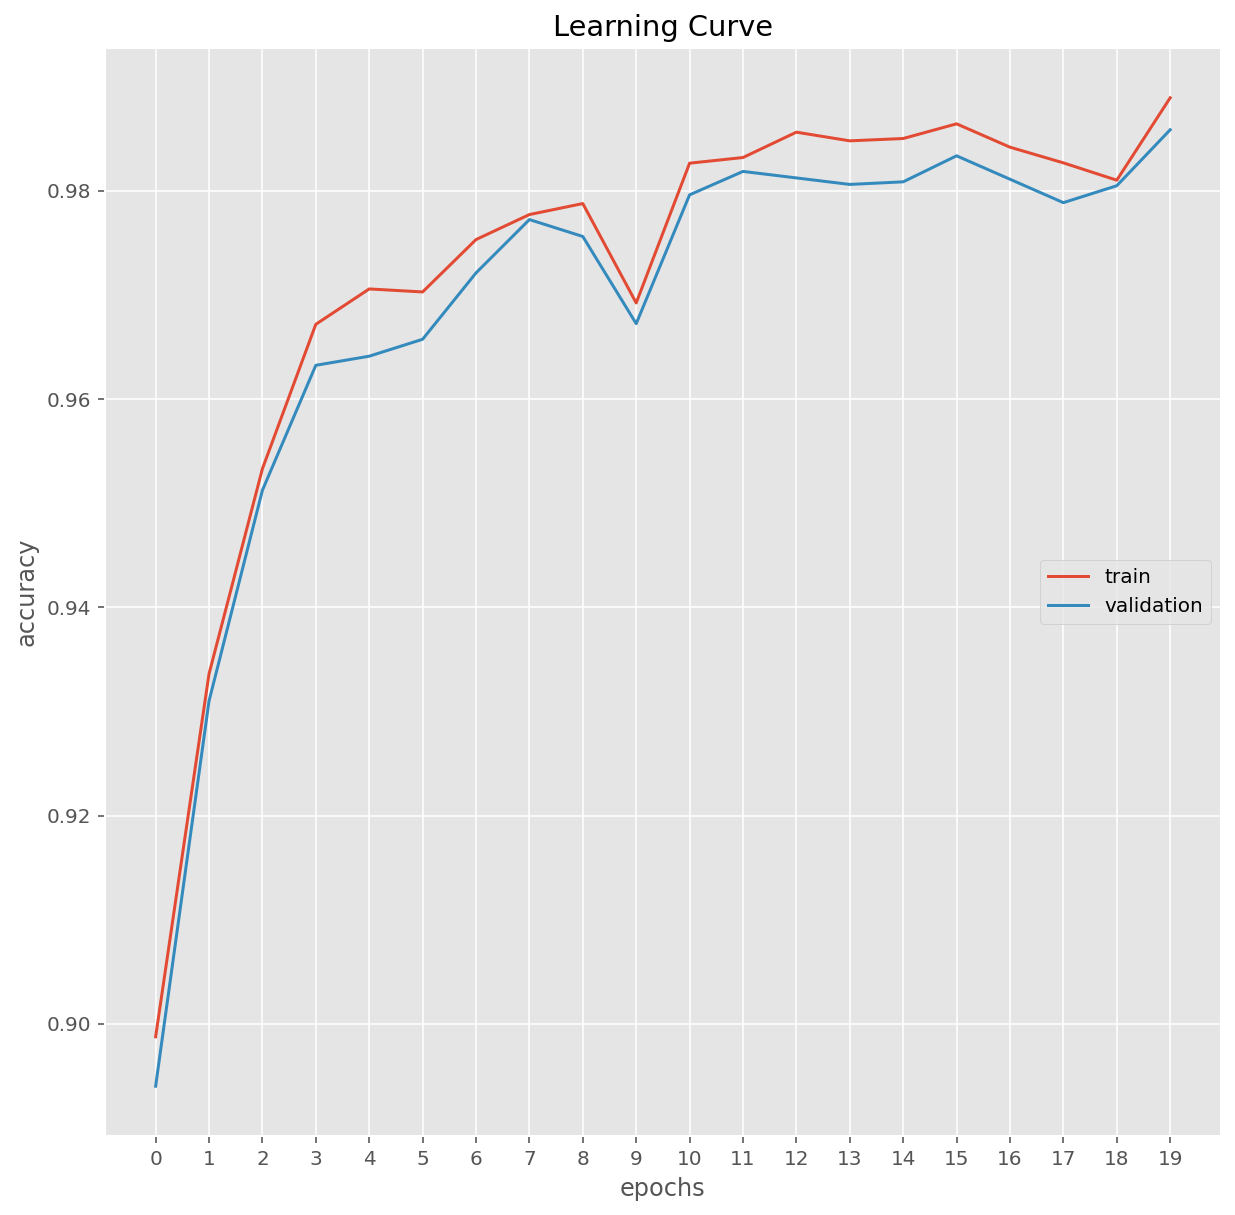

In [88]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network3(), make_adam(1.0e-3))
    learning_curve = train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network3_epochs-20.ckpt')
    
show_learning_curve(learning_curve)

INFO:tensorflow:Restoring parameters from checkpoint/network3_epochs-20.ckpt


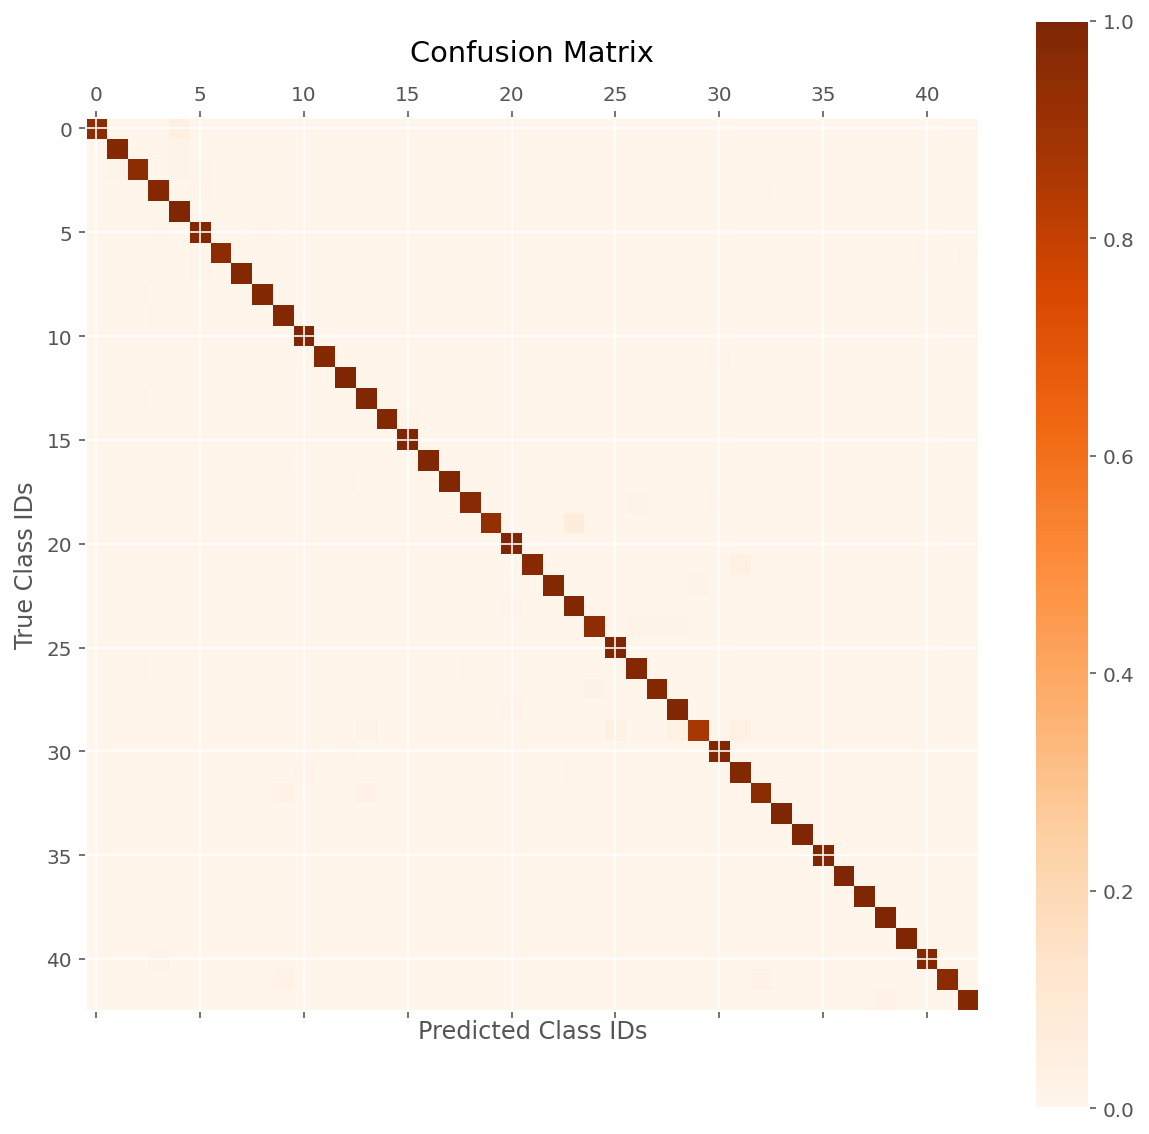

4 Speed limit (70km/h)                               100.00% 1576
12 Priority road                                      100.00% 1672
15 No vehicles                                        100.00%  501
20 Dangerous curve to the right                       100.00%  287
25 Road work                                          100.00% 1194
33 Turn right ahead                                   100.00%  548
34 Turn left ahead                                    100.00%  334
35 Ahead only                                         100.00%  955
36 Go straight or right                               100.00%  310
37 Go straight or left                                100.00%  167
39 Keep left                                          100.00%  239
38 Keep right                                          99.76% 1648
10 No passing for vehicles over 3.5 metric tons        99.76% 1600
17 No entry                                            99.56%  884
13 Yield                                               99.32% 1

In [89]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network3())
    session.load('checkpoint/network3_epochs-20.ckpt')  
    pred = pipeline.predict(X_valid)
    
# examine confusionconfusion_matrixix
cm = confusion_matrix(y_valid, pred)
plot_confusion_matrix(cm)
print_confusion_matrix(cm)

**Observation**:

The performance did improve but not in the last several epochs.  

100% accuracy is achieved for more classes.  Also, the bottom performer is improving as well.

## Network 3 with More Epochs and Lower Learning Rate

Let's try a lower learning rate with epochs=20.

Epoch:   0 Train Score: 0.835 Evaluation Score: 0.829
Epoch:   1 Train Score: 0.919 Evaluation Score: 0.915
Epoch:   2 Train Score: 0.944 Evaluation Score: 0.939
Epoch:   3 Train Score: 0.965 Evaluation Score: 0.958
Epoch:   4 Train Score: 0.966 Evaluation Score: 0.961
Epoch:   5 Train Score: 0.966 Evaluation Score: 0.964
Epoch:   6 Train Score: 0.975 Evaluation Score: 0.971
Epoch:   7 Train Score: 0.980 Evaluation Score: 0.981
Epoch:   8 Train Score: 0.971 Evaluation Score: 0.967
Epoch:   9 Train Score: 0.983 Evaluation Score: 0.979
Epoch:  10 Train Score: 0.983 Evaluation Score: 0.981
Epoch:  11 Train Score: 0.984 Evaluation Score: 0.983
Epoch:  12 Train Score: 0.981 Evaluation Score: 0.977
Epoch:  13 Train Score: 0.988 Evaluation Score: 0.984
Epoch:  14 Train Score: 0.987 Evaluation Score: 0.983
Epoch:  15 Train Score: 0.989 Evaluation Score: 0.987
Epoch:  16 Train Score: 0.989 Evaluation Score: 0.987
Epoch:  17 Train Score: 0.990 Evaluation Score: 0.987
Epoch:  18 Train Score: 0.98

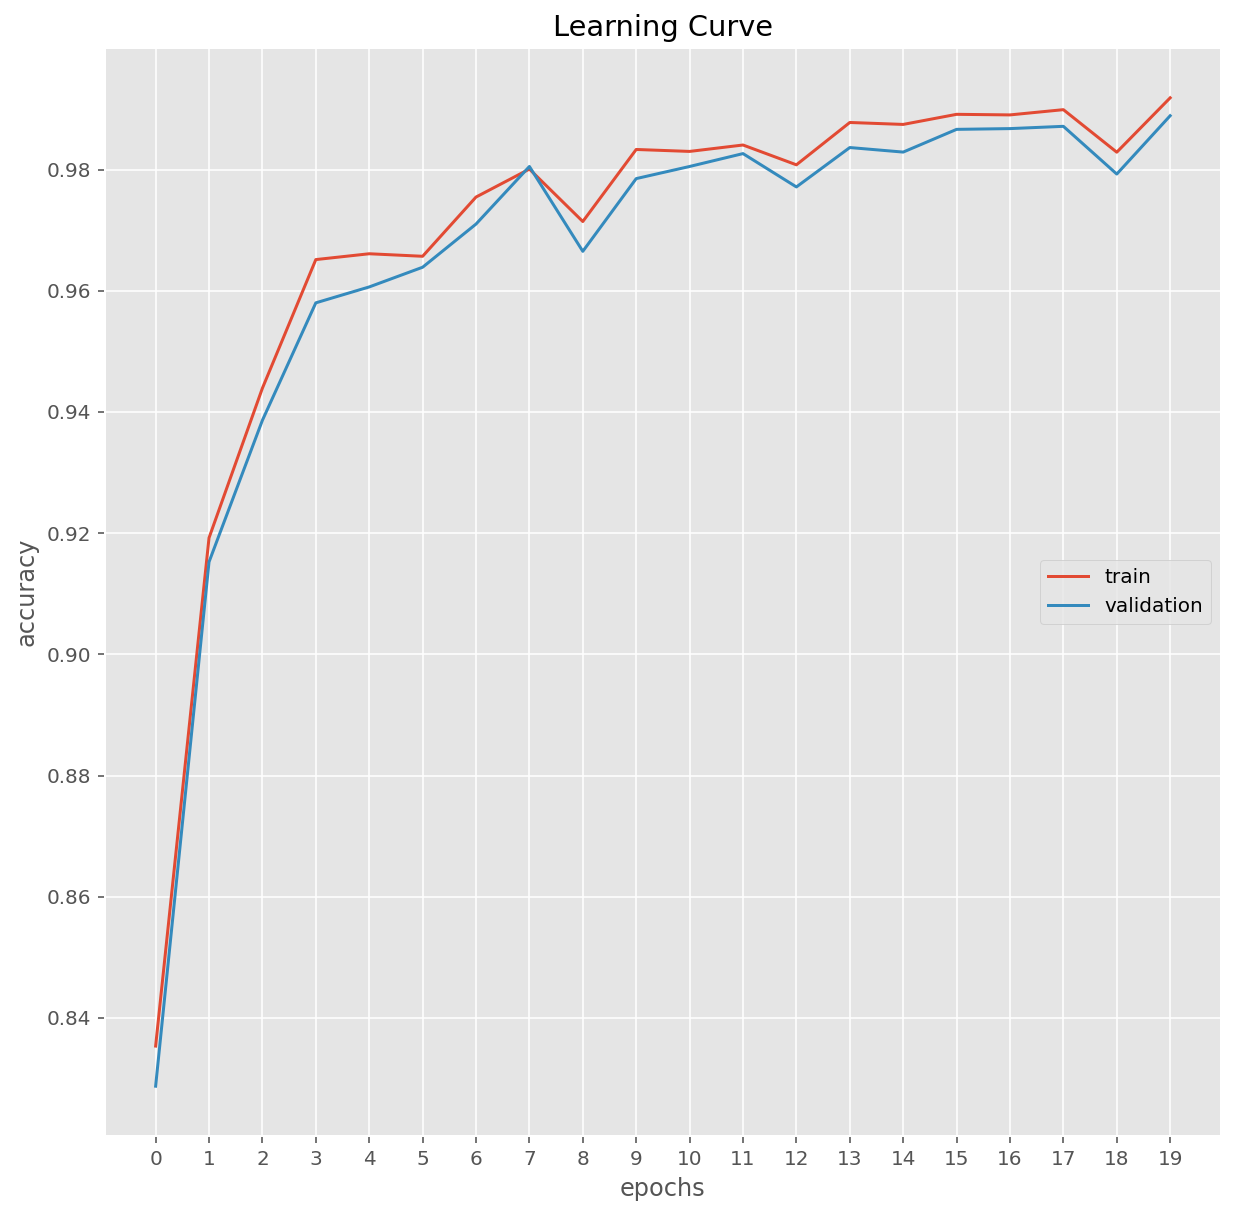

In [90]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network3(), make_adam(0.5e-3)) # <== lower learning rate
    learning_curve = train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network3_epochs-20_lr-0.5e-3.ckpt')
    
show_learning_curve(learning_curve)

INFO:tensorflow:Restoring parameters from checkpoint/network3_epochs-20_lr-0.5e-3.ckpt


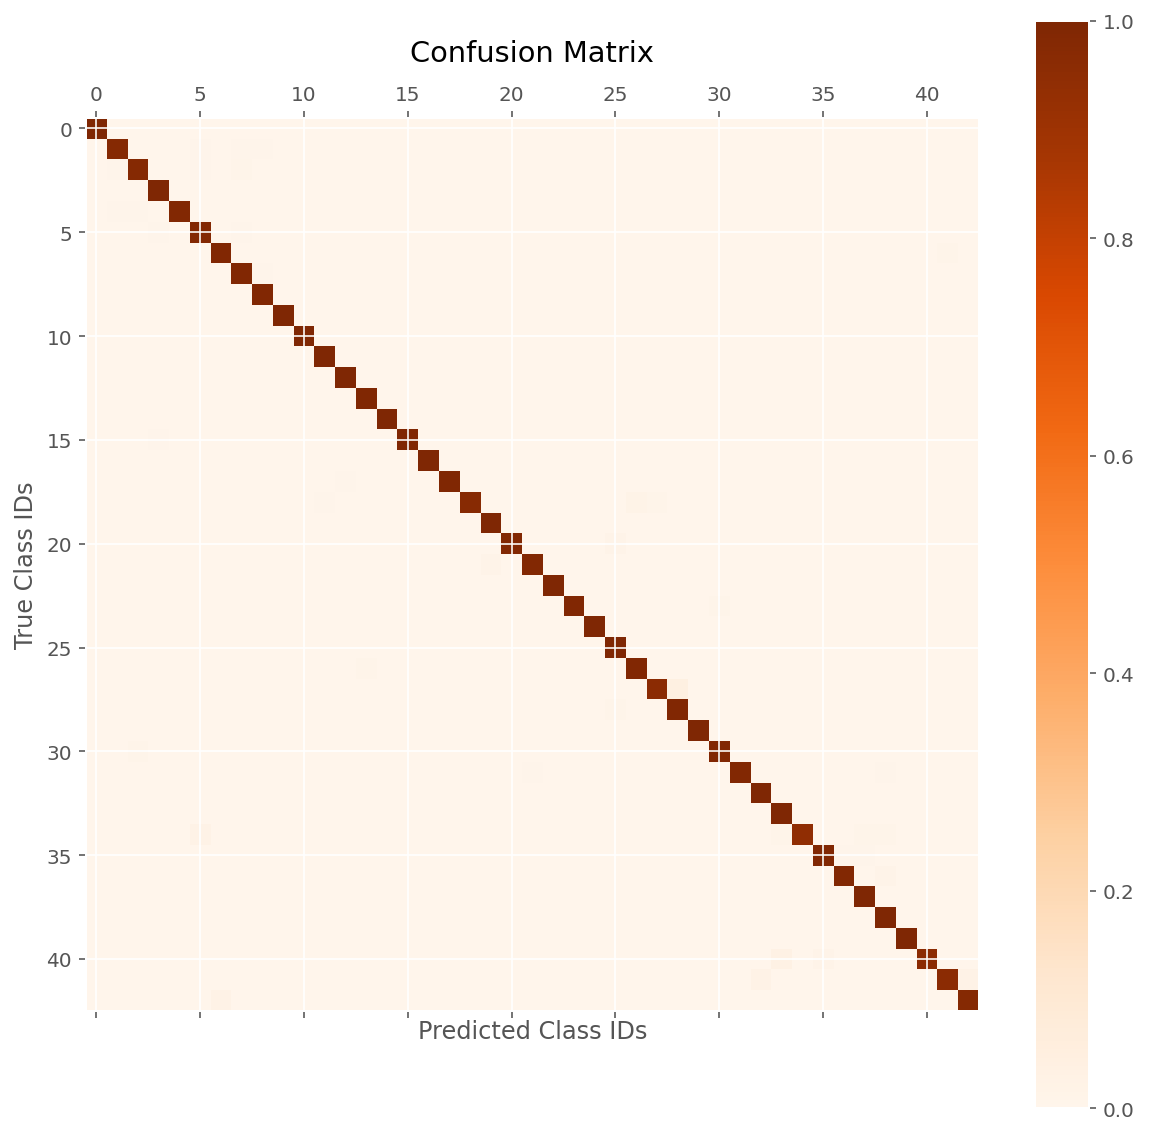

0 Speed limit (20km/h)                               100.00%  167
 3 Speed limit (60km/h)                               100.00% 1122
10 No passing for vehicles over 3.5 metric tons       100.00% 1600
11 Right-of-way at the next intersection              100.00% 1051
12 Priority road                                      100.00% 1672
14 Stop                                               100.00%  621
16 Vehicles over 3.5 metric tons prohibited           100.00%  334
19 Dangerous curve to the left                        100.00%  167
22 Bumpy road                                         100.00%  310
24 Road narrows on the right                          100.00%  215
29 Bicycles crossing                                  100.00%  215
32 End of all speed and passing limits                100.00%  191
33 Turn right ahead                                   100.00%  548
37 Go straight or left                                100.00%  167
39 Keep left                                          100.00%  

In [91]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network3())
    session.load('checkpoint/network3_epochs-20_lr-0.5e-3.ckpt')  
    pred = pipeline.predict(X_valid)
    
# examine confusionconfusion_matrixix
cm = confusion_matrix(y_valid, pred)
plot_confusion_matrix(cm)
print_confusion_matrix(cm)
raise SystemExit("Stop right there!")

**Observation**:

The performance is almost the same  or slightly better.  The learning curve looks much smoother.  The average accuracy per class is slightly better, too.  Overall, I believe the smaller learning rate was a worthy change.

### Netowrk 3 Even Smaller Learning Rate

In [92]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network3(), make_adam(1.0e-4)) # <== lower learning rate
    learning_curve = train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network3_epochs-20_lr-1.0e-4.ckpt')
    
show_learning_curve(learning_curve)

Epoch:   0 Train Score: 0.514 Evaluation Score: 0.511


KeyboardInterrupt: 

In [ ]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network3())
    session.load('checkpoint/network3_epochs-20_lr-1.0e-4.ckpt')  
    pred = pipeline.predict(X_valid)
    
# examine confusionconfusion_matrixix
cm = confusion_matrix(y_valid, pred)
plot_confusion_matrix(cm)
print_confusion_matrix(cm)

**Observation**:

- The performance is worse and it seems to show some overfitting in the end.  
- The learning curve is much more smoother.
- The mean accuracy per class is worse and its standard devaition is bigger.

Let's stick with the previous learning rate for the time being.

## Network 4

Let's try leaky ReLU (to avoid dead ReLU issue if any)

In [ ]:
def make_network4(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
            .input(input_shape)
            .conv([5, 5, 24])
            .max_pool()
            .relu(leak_ratio=0.01) # <== leaky ReLU
            .conv([5, 5, 64])
            .max_pool()
            .relu(leak_ratio=0.01) # <== leaky ReLU
            .flatten()
            .dense(480)
            .relu(leak_ratio=0.01) # <== leaky ReLU
            .dense(N_CLASSES))

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network4(), make_adam(0.5e-3))
    learning_curve = train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network4.ckpt')

show_learning_curve(learning_curve)

**Observation**:

No improvment.

## Network 5

ELU (Exponential Linear Unit) activation which is supposed to be faster to learn than ReLU.

Reference: http://www.picalike.com/blog/2015/11/28/relu-was-yesterday-tomorrow-comes-elu/

In [ ]:
def make_network5(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
            .input(input_shape)
            .conv([5, 5, 24])
            .max_pool()
            .elu()              # <== ELU
            .conv([5, 5, 64])
            .max_pool()
            .elu()              # <== ELU
            .flatten()
            .dense(480)
            .elu()              # <== ELU
            .dense(N_CLASSES))

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network5(), make_adam(0.5e-3))
    learning_curve = train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network5.ckpt')
    
show_learning_curve(learning_curve)

**Observation**:

The permance is worse.  Also, it did not learn faster.

## Network 6

Let's try smaller initial weight value.

In [ ]:
def make_network6(input_shape=INPUT_SHAPE):
    return (NeuralNetwork(weight_sigma=0.01) # <== smaller weight sigma
            .input(input_shape)
            .conv([5, 5, 24])
            .max_pool()
            .relu()
            .conv([5, 5, 64])
            .max_pool()
            .relu()
            .flatten()
            .dense(480)
            .relu()
            .dense(N_CLASSES))

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network6(), make_adam(0.5e-3))
    learning_curve = train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network6.ckpt')
    
show_learning_curve(learning_curve)

**Observation**:

Not an improvement - a bit worse.

## Network 7

Adding one more dense layer.

In [ ]:
def make_network7(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
            .input(input_shape)
            .conv([5, 5, 24])
            .max_pool()
            .relu()
            .conv([5, 5, 64])
            .max_pool()
            .relu()
            .flatten()
            .dense(480)
            .relu()
            .dense(240) # <== one more dense layer
            .relu()
            .dense(N_CLASSES))

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network7(), make_adam(0.5e-3))
    learning_curve = train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network7.ckpt')
    
show_learning_curve(learning_curve)

**Observation**:

No improvment - a bit worse.

## Network 8

The same as Network 3 but using MaxPooling after ReLU.

In [ ]:
def make_network8(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
            .input(input_shape)
            .conv([5, 5, 24])
            .relu()     
            .max_pool() # <== after ReLU
            .conv([5, 5, 64])
            .relu()
            .max_pool() # <== after ReLU
            .flatten()
            .dense(480)
            .relu()
            .dense(N_CLASSES))

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network8(), make_adam(0.5e-3))
    learning_curve = train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network8.ckpt')
    
show_learning_curve(learning_curve)

**Observation**:

No improvement - about the same.

## Network 9

Let's try 3 convolutional layers.

In [ ]:
def make_network9(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
            .input(input_shape)
            .conv([5, 5, 24])
            .max_pool()
            .relu()
            .conv([5, 5, 64])
            .max_pool()
            .relu()
            .conv([3, 3, 64])  # <= smaller kernel here (the image is small by here)
            .max_pool()
            .relu()
            .flatten()
            .dense(480)
            .relu()
            .dense(N_CLASSES))

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network9(), make_adam(0.5e-3))
    learning_curve = train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network9.ckpt')
    
show_learning_curve(learning_curve)

**Observation**

No improvment - a bit worse.

## Network 3 with Momentum Optimizer

In [ ]:
for momentum in [0.7, 0.8, 0.9]:
    with Session() as session:
        print('Momentum: {}'.format(momentum))
        optimizer = tf.train.MomentumOptimizer(learning_rate=0.5e-3, momentum=momentum)
        pipeline = build_pipeline(preprocessors, session, make_network3(), optimizer)
        train_evaluate(pipeline, epochs=20)
        session.save('checkpoint/network3_momentum_{}.ckpt'.format(momentum))
        print()

**Observation**:

Got worse.

## Network 3 with Balanced Class Distribution of Training Data

Will it help to have a balanced class distribution of training data?

In [ ]:
def balance_distribution(X, y, size):
    X_balanced = []
    y_balanced = []
    for c in range(N_CLASSES):
        data = X[y==c]
        indices = np.random.choice(sum(y==c), size)
        X_balanced.extend(X[y==c][indices])
        y_balanced.extend(y[y==c][indices])
    return np.array(X_balanced), np.array(y_balanced)

X_balanced, y_balanced = balance_distribution(X_train, y_train, 3000)

show_class_distribution(y_balanced, 'Balanced Train Set')

Let's try the balanced data set with our best pipeline (Network 3 with learning rate = 0.5e-3)

In [ ]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network3(), make_adam(0.5e-3))
    learning_curve = train_evaluate(pipeline, epochs=20, train=(X_balanced, y_balanced)) # <== using the balanced train set
    session.save('checkpoint/network3_with_balanced_data.ckpt')

show_learning_curve(learning_curve)

**Observation**:

The validation accuracy is much worse than before.  This is likely because the distribution is different, indicating the network is learning the distribution which is different from the validation set.  Assuming the test set has the same kind of validation (we should not check the test set at this stage), using the balance set may not be a good idea.

Instead, we should do more epochs so that minor classes are more visible to the network.

## Network 3 with even more epochs

Let's just try with much more epochs.

In [ ]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network3(), make_adam(0.5e-3)) 
    learning_curve = train_evaluate(pipeline, epochs=100)
    
show_learning_curve(learning_curve)

**Observation**:

It performs much better now but the last several epochs are not really helping for the network to learn.  I should try smaller learning rate to see how it goes.

## Network 3 with even lower learning rate (and more epochs)

In [ ]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network3(), make_adam(1.0e-4))
    learning_curve = train_evaluate(pipeline, epochs=500)
    session.save('checkpoint/network3_epochs-500_lr-1.0e-4.ckpt')    
    
show_learning_curve(learning_curve)

**Observation**:

The performance has improved.  It appears that 100 epochs are enough to achieve this performance.  

Is this as good as it can get?

## Network 10 

Can we make the network more robust?  How about a dropout?

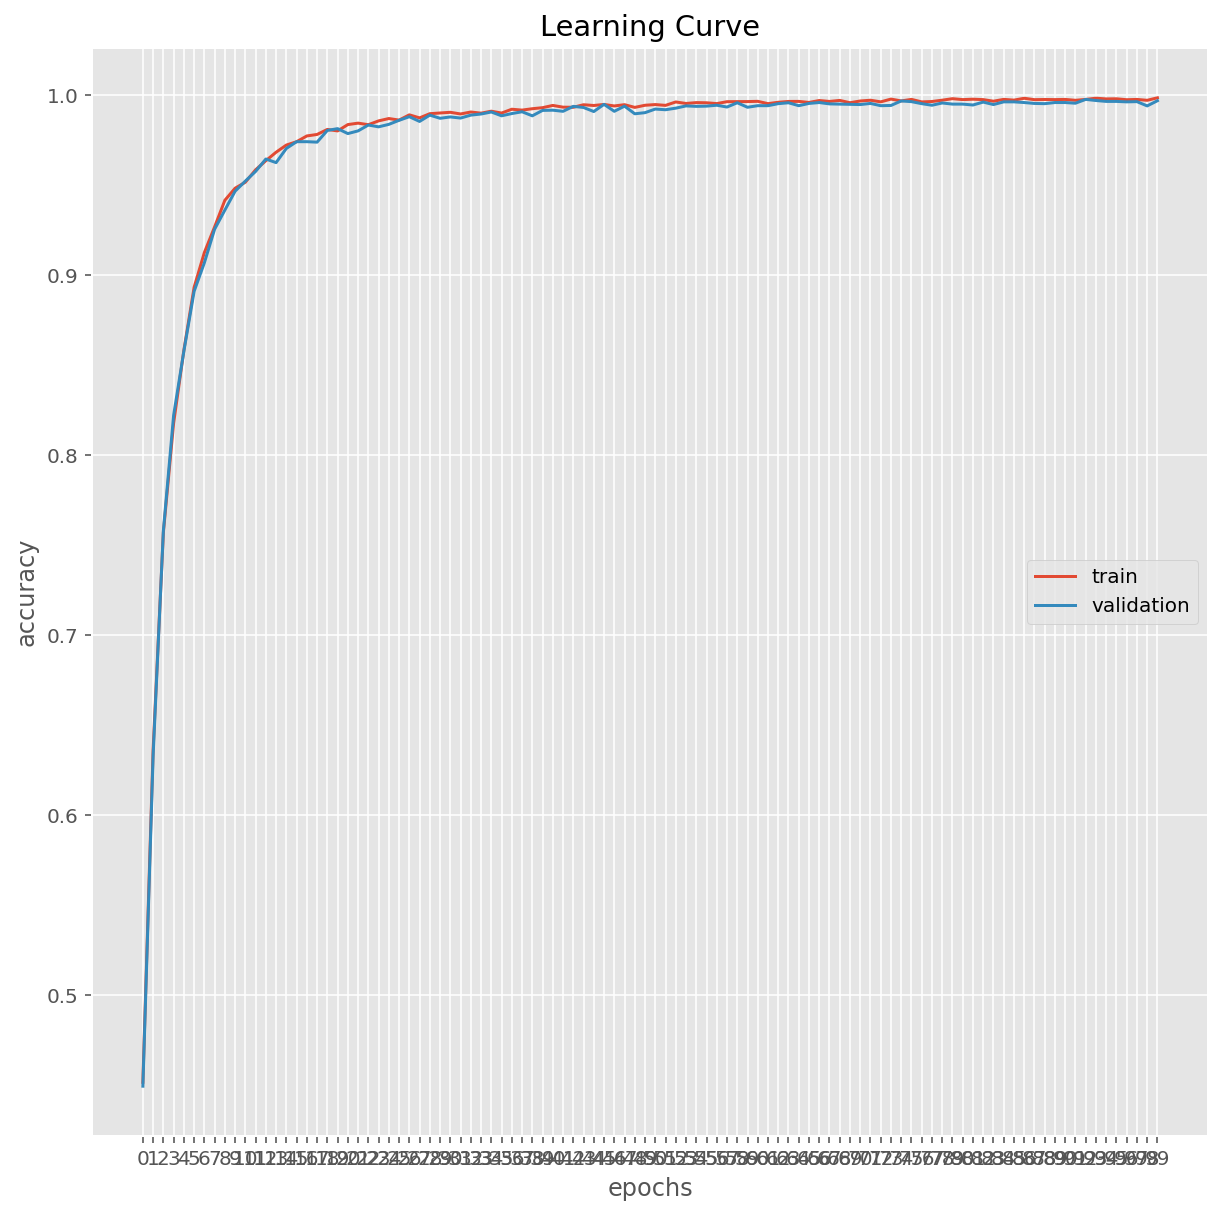

In [54]:
show_learning_curve(learning_curve)

In [44]:
def make_network10(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
            .input(input_shape)
            .conv([5, 5, 24])
            .max_pool()
            .relu()
            .conv([5, 5, 64])
            .max_pool()
            .relu()
            .dropout(keep_prob=0.5)
            .flatten()
            .dense(480)
            .relu()
            .dense(N_CLASSES))

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network10(), make_adam(1.0e-4))
    learning_curve = train_evaluate(pipeline, epochs=100)
    session.save('checkpoint/network10.ckpt')
    


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.Flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Epoch:   0 Train Score: 0.452 Evaluation Score: 0.450
Epoch:   1 Train Score: 0.636 Evaluation Score: 0.633
Epoch:   2 Train Score: 0.757 Evaluation Score: 0.758
Epoch:   3 Train Score: 0.818 Evaluation Score: 0.822
Epoch:   4 Train Score: 0.858 Evaluation Score: 0.858
Epoch:   5 Train Score: 0.893 Evaluation Score: 0.891
Epoch:   6 Train Score: 0.913 Evaluation Score: 0.907
Epoch:   7 Train Score: 0.927 Evaluation Score: 0.925
Epoch:   8 Train Score: 0.942 Evaluation Score: 0

NameError: name 'show_learning_curve' is not defined

INFO:tensorflow:Restoring parameters from checkpoint/network10.ckpt


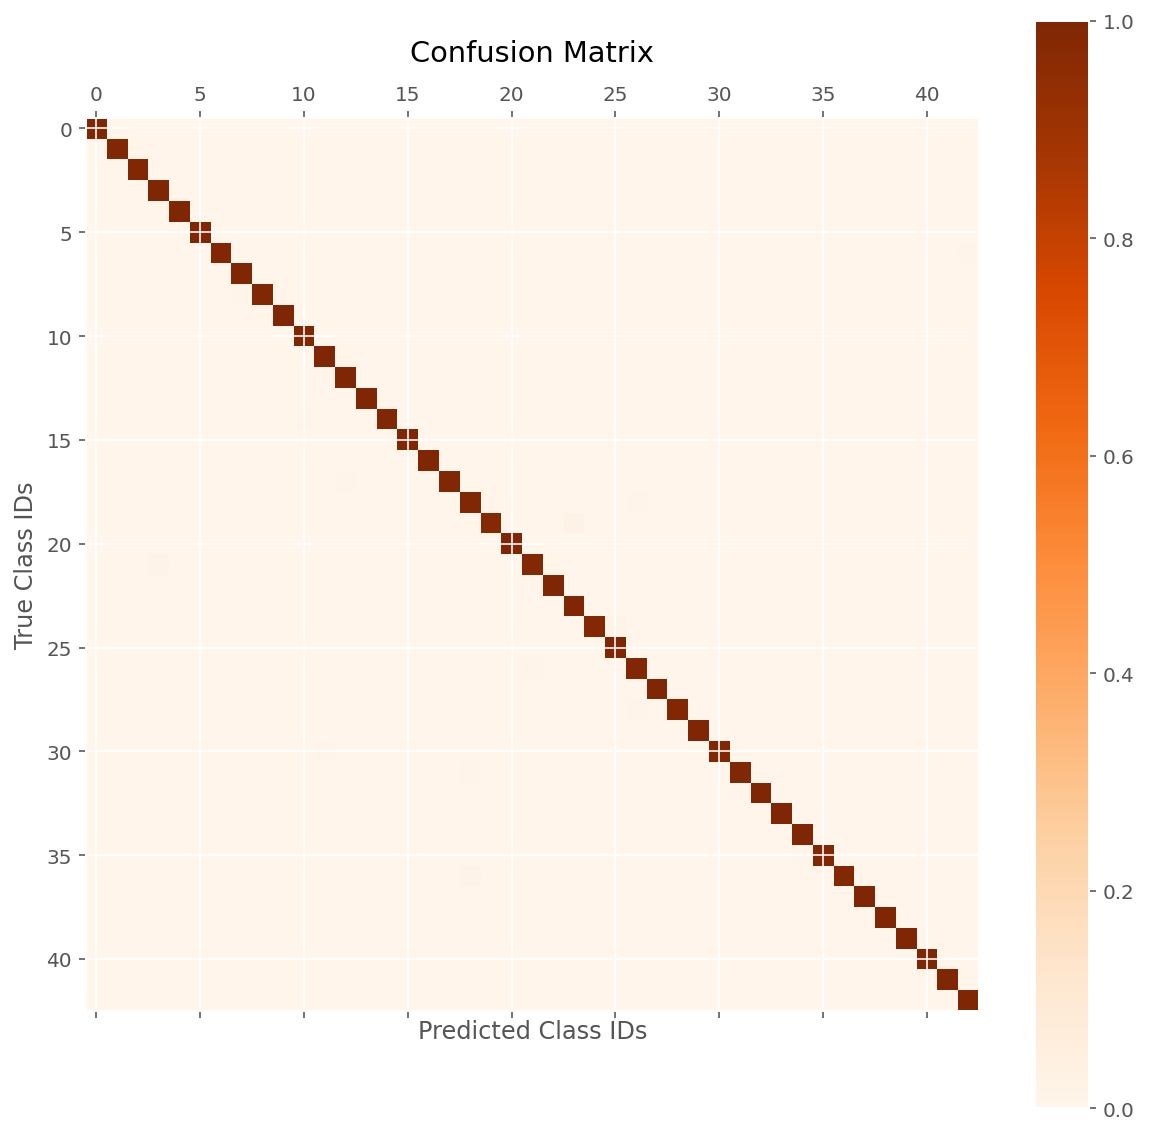

0 Speed limit (20km/h)                               100.00%  167
 4 Speed limit (70km/h)                               100.00% 1576
 7 Speed limit (100km/h)                              100.00% 1146
10 No passing for vehicles over 3.5 metric tons       100.00% 1600
11 Right-of-way at the next intersection              100.00% 1051
12 Priority road                                      100.00% 1672
15 No vehicles                                        100.00%  501
16 Vehicles over 3.5 metric tons prohibited           100.00%  334
20 Dangerous curve to the right                       100.00%  287
22 Bumpy road                                         100.00%  310
23 Slippery road                                      100.00%  406
25 Road work                                          100.00% 1194
27 Pedestrians                                        100.00%  191
29 Bicycles crossing                                  100.00%  215
32 End of all speed and passing limits                100.00%  

In [57]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network10())
    session.load('checkpoint/network10.ckpt')  
    pred = pipeline.predict(X_valid)
    
# examine confusionconfusion_matrixix
cm = confusion_matrix(y_valid, pred)
plot_confusion_matrix(cm)
print_confusion_matrix(cm)

**Observation**:

The validation performance is more stable now.  500 epochs is probably overkill.

## Preprocessing (Again)

These are extra experiments to see if we can improve the pipeline further.  I did experiment with these preprocessing before the network was fully trained and the effect was sort of random (sometimes good, other times bad).  As such I discarded the idea.

But I'm re-doing it to see if it has positive effect after the network is fully trained.  

The conclusion in short is that they don't work well.  This is very likely due to the network trained without them.  It seems abundantly clear in hindsight.  

The below are a series of unfortunately experiments, proving how bad idea it was to change preprocessing after the training.


### Image Enhancement

Taking a weighted average of the original image and the blurred image to make in order to smooth out the noises.

In [ ]:
def enhance_image(image, ksize, weight):
    blurred = cv2.GaussianBlur(image, (ksize, ksize), 0)
    return cv2.addWeighted(image, weight, blurred, -weight, image.mean())

In [ ]:
for ksize in [5, 7, 9, 11]:
    for weight in [4, 6, 8, 10]:
        print('Enhancer: k={} w={}'.format(ksize, weight))
        with Session() as session:
            enhancer = lambda x: enhance_image(x, ksize, weight)
            functions = [loader, augmenter, enhancer, normalizer]
            pipeline = build_pipeline(functions, session, make_network10())
            session.load('checkpoint/network10.ckpt')
            score = pipeline.score(X_valid, y_valid)
            print('Validation Score: {}'.format(score))
        print()

In [ ]:
enhancer = lambda x: enhance_image(x, 9, 8)

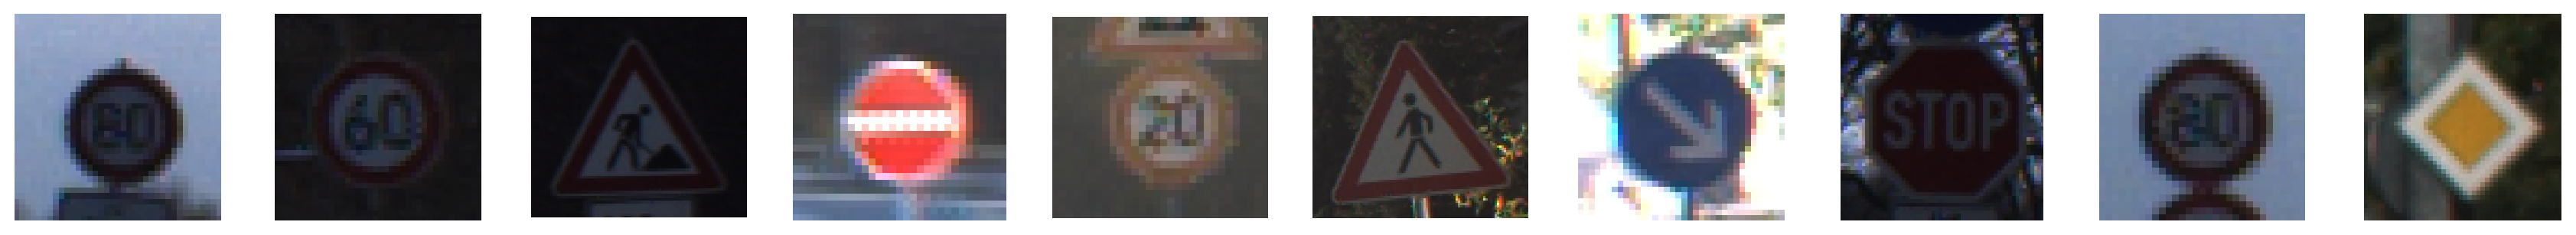

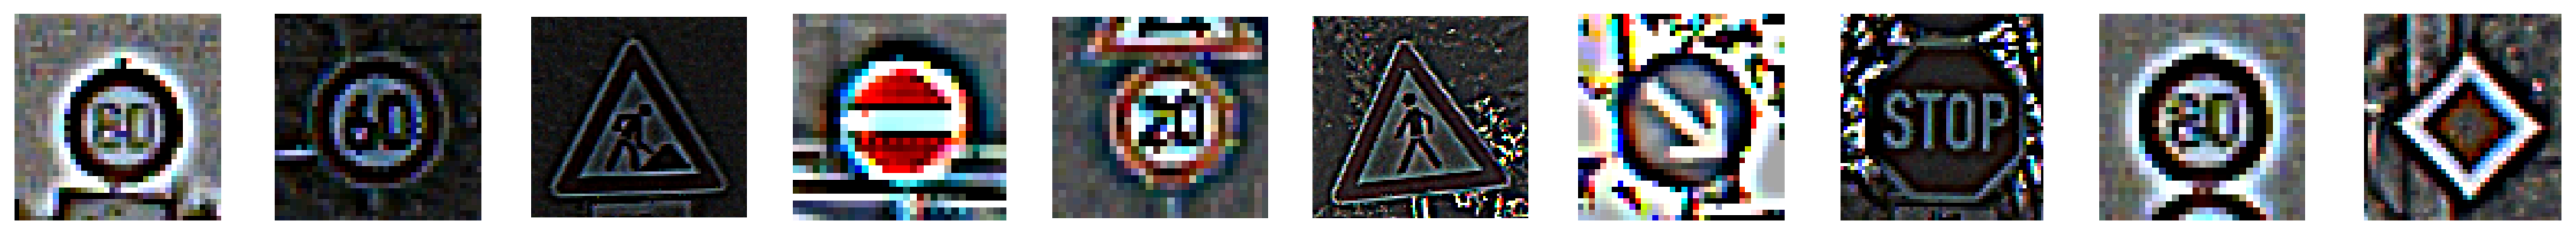

In [56]:
show_images(sample_data[10:], cols=10)
show_images(sample_data[10:], cols=10, func=enhancer)

**Observations**:

I tried these earlier and the result was pretty random.  Sometimes, it improves but not other times.  

If I do this with the pre-trained network as shown above, the result is worse as the network is already tuned for images not using the enhancements.  

Perhaps, I should try to use it during the training to see if it speed up the training or not.

However, as the network performs really well without this, my conclusion is not to use this filter at all.

## Histogram Equalizaition

In [57]:
def equalizer(image):
    image = image.copy()
    for i in range(3):
        image[:, :, i] = cv2.equalizeHist(image[:, :, i])
    return image

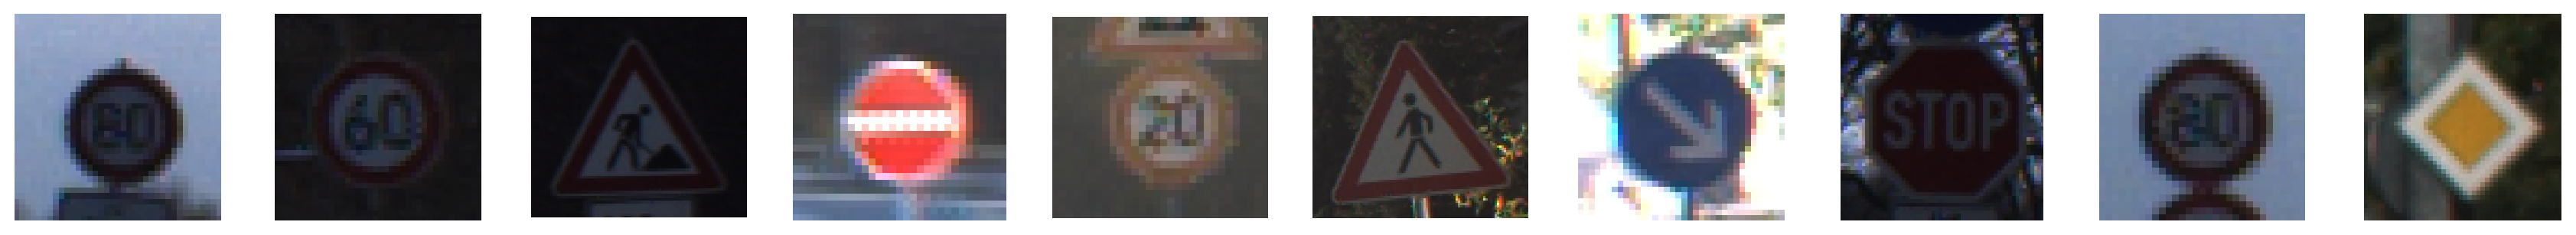

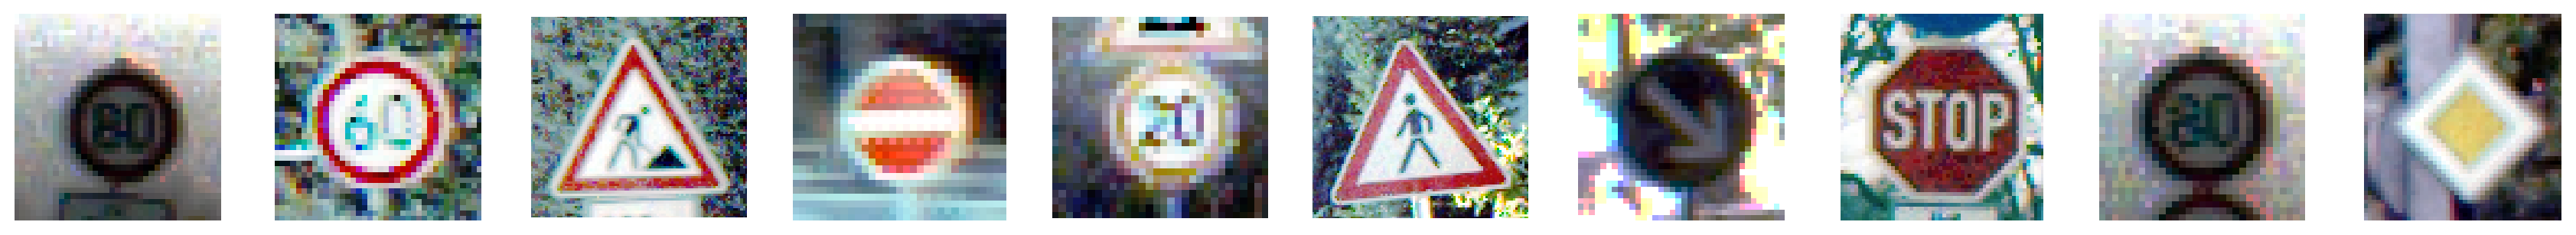

In [58]:
show_images(sample_data[10:], cols=10)
show_images(sample_data[10:], cols=10, func=equalizer)

In [59]:
with Session() as session:
    functions = [loader, augmenter, equalizer, normalizer]
    pipeline = build_pipeline(functions, session, make_network10())
    session.load('checkpoint/network10.ckpt')
    score = pipeline.score(X_valid, y_valid)
    print('Validation Score: {:.3f}'.format(score))

Validation Score: 0.904


**Observation**:

If this was tried before the network was fully trained, it might have made the learning easier.  Earlier, I played with this preprocessing before training but it was not producing better results than the enhancer.  Maybe I will re-try that one day.

How about combine the histogram equalizer and the enhancer?

In [65]:
with Session() as session:
    functions = [loader, augmenter, equalizer, enhancer, normalizer]
    pipeline = build_pipeline(functions, session, make_network10())
    session.load('checkpoint/network10.ckpt')
    score = pipeline.score(X_valid, y_valid)
    print(score)

0.67775


**Observaton**:

The histogram equalizer + enhancer does not improve.

## Min Max Normalization

http://docs.opencv.org/2.4/modules/core/doc/operations_on_arrays.html#normalize

In [62]:
def min_max_norm(image):
    return cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

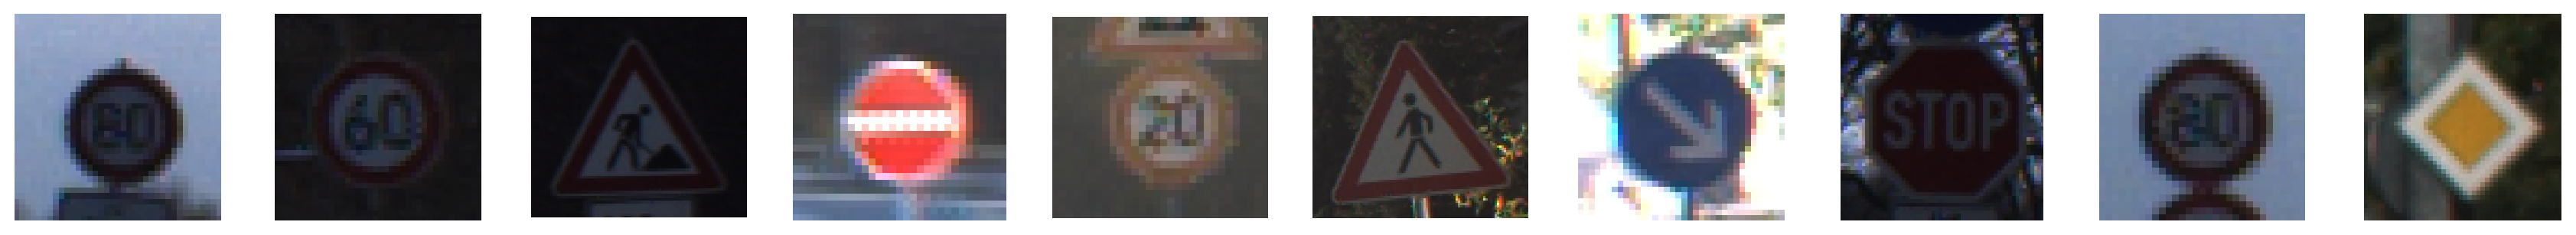

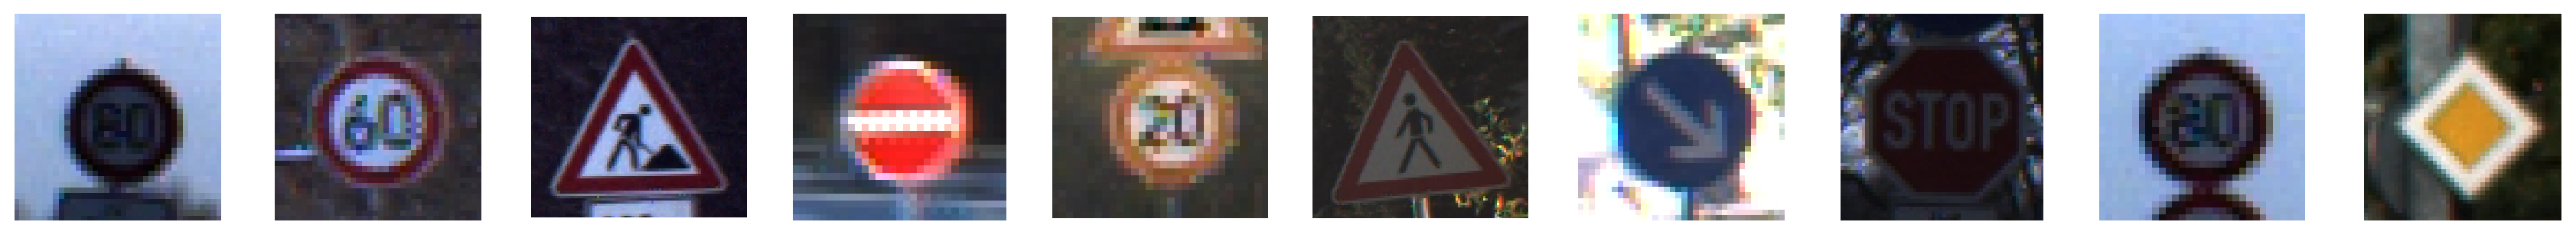

In [63]:
show_images(sample_data[10:], cols=10)
show_images(sample_data[10:], cols=10, func=min_max_norm)

In [66]:
with Session() as session:
    functions = [loader, augmenter, min_max_norm, normalizer]
    pipeline = build_pipeline(functions, session, make_network10())
    session.load('checkpoint/network10.ckpt')
    score = pipeline.score(X_valid, y_valid)
    print(score)

0.99825


**Observaton**:

I tried Min-Max normalizer before fully training the network and did not get any good results.

This experiment here is just to check if it can do any good once the network is fully trained.  It proves the otherwise.

Let's try the combination with the enhancer.

In [67]:
with Session() as session:
    functions = [loader, augmenter, min_max_norm, enhancer, normalizer]
    pipeline = build_pipeline(functions, session, make_network10())
    session.load('checkpoint/network10.ckpt')
    score = pipeline.score(X_valid, y_valid)
    print(score)

0.79925


**Observation**:

The same argument here.  I don't need this.

## Test Dataset

Test images are in one folder.  So, we can simply load them as follows:

Test images do not have category folders but all are kept in one place with one label file.

```
data
 + Final_Test
    + Images
        + 00000.ppm
        + 00001.ppm
        + ...
        + GT-final_test.csv      # Extended annotations including class ids
        + GT-final_test.test.csv
```

I also downloaded GT-final_test.csv which contains extended annotations including class ids for test images.

In [63]:
TEST_IMAGE_DIR = 'data\\Final_Test\\Images'

# Note: GT-final_test.csv comes with class IDs (GT-final_test.test.csv does not)
test_df = pd.read_csv(os.path.join(TEST_IMAGE_DIR, 'GT-final_test.csv'), sep=';')
test_df['Filename'] = test_df['Filename'].apply(lambda x: os.path.join(TEST_IMAGE_DIR, x))
test_df.head()

Filename  Width  Height  Roi.X1  Roi.Y1  Roi.X2  \
0  data\Final_Test\Images\00000.ppm     53      54       6       5      48   
1  data\Final_Test\Images\00001.ppm     42      45       5       5      36   
2  data\Final_Test\Images\00002.ppm     48      52       6       6      43   
3  data\Final_Test\Images\00003.ppm     27      29       5       5      22   
4  data\Final_Test\Images\00004.ppm     60      57       5       5      55   

   Roi.Y2  ClassId  
0      49       16  
1      40        1  
2      47       38  
3      24       33  
4      52       11

In [64]:
print("Number of test images: {:>5}".format(test_df.shape[0]))

Number of test images: 12630


In [65]:
X_test = test_df['Filename'].values
y_test = test_df['ClassId'].values

In [68]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network3())
    session.load('checkpoint/network10.ckpt')
    score = pipeline.score(X_test, y_test)
    print('Test Score: {}'.format(score))

INFO:tensorflow:Restoring parameters from checkpoint/network10.ckpt
Test Score: 0.9529691211401425


**Observation**:

It's about 96% accuracy.  For the simple network like this one, it did a really good work.

I probably need more complex network than this one but I'd need a better hardware to train one of those.  Even with AWS g2 instance is not fast enough to run 500 epochs.

# Testing with Random Images

In [ ]:
X_new = np.array(glob.glob('images/sign*.jpg') + 
                 glob.glob('images/sign*.png'))

In [ ]:
new_images = [plt.imread(path) for path in X_new]

In [ ]:
print('-' * 80)
print('New Images for Random Testing')
print('-' * 80)

plt.figure(figsize=(15,5))
for i, image in enumerate(new_images):
    plt.subplot(2,len(X_new)//2,i+1)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])    
plt.show()

In [ ]:
print('getting top 5 results')

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network3())
    session.load('checkpoint/network10.ckpt')  
    prob = pipeline.predict_proba(X_new)
    estimator = pipeline.steps[-1][1]
    top_5_prob, top_5_pred = estimator.top_k_

print('done')

In [ ]:
print('-' * 80)
print('Top 5 Predictions')
print('-' * 80)

for i, (preds, probs, image) in enumerate(zip(top_5_pred, top_5_prob, new_images)):
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    for pred, prob in zip(preds.astype(int), probs):
        sign_name = SIGN_NAMES[pred]
        print('{:>5}: {:<50} ({:>14.10f}%)'.format(pred, sign_name, prob*100.0))
    print('-' * 80)    

**Observation**:

7 out of 10 are correct.

- The pedestrian     : This is actually not German traffic sign.
- Speed limit (80km) : The model believed it was for 30km. 
- Speed limit (100km): The model believed it was for 80km.

I can understand why it did not identify the pedestrian correctly as it's not a German traffic sign.  But it's quite similar to it.  So, a human would have recognized this.  This means that the machine learned only the shapes but not the concept, which is understandable from the way convolutional neural network works.

This also means that for every country / region, we'd need to train the classifier to recognize their traffic signs.

As for the speed limits (80km and 100km), I'm thinking it is may be due to the image distortion by the resizing operation.  We may need a better way to resize images.  But this is yet to be proven at this stage.

# Conclusion

The use of pipelines were very effective during the experimentations.  In the end, the traffic sign classifier works pretty well overall with the test set.  

However, the network did not work as good with ramdom sample images from the internet.  

Moreover, if a self-driving car needs to find traffic signs in public, it first needs to know where the traffic signs are.  It's a chicken and egg problem.

Therefore, we will need an object recognition mechanism that scan across the image with sliding windows to find the candidate signs.  This kind of detection mechanism is not covered in this project.

# References:
    
- German Traffic Sign Benchmarks: http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset
- The PPM format (Portable Pixmap, P6): http://en.wikipedia.org/wiki/Netpbm_format
- LeNet Demo (Yann LeCun): http://yann.lecun.com/exdb/lenet/
- Gradient-Based Learning Applied to Document Recognition (Yann LeCun): http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf
- Udacity: Self-Driving Car Engineer: Traffic Sign Classifier Project: https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project
